<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #1: Perceptrones Multicapa o Redes FF </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import cPickle as pickle
import os
from scipy.misc import imread

# sklearn utilities
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold

# keras functionalities
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using Theano backend.


## Table de Contenidos
* [El XOR](#xor)
    * [Parte (a)](#1a)
    * [Parte (b)](#1b)
    * [Parte (c)](#1c)
* [Predicción del precio de una casa](#pred)
    * [Parte (a)](#2a)
    * [Parte (b)](#2b)
    * [Parte (c)](#2c)
    * [Parte (d)](#2d)
    * [Parte (e)](#2e)
    * [Parte (f)](#2f)
    * [Parte (g)](#2g)
    * [Parte (h)](#2h)
    * [Parte (i)](#2i)
    * [Parte (j)](#2j)
* [Reconocimiento de imágenes en CIFAR10](#rec)
    * [Parte (a)](#3a)
    * [Parte (b)](#3b)
    * [Parte (c)](#3c)
    * [Parte (d)](#3d)

<div id='xor' />
## 1.-  El XOR

<div id='1a' />
### Parte (a)

La función `xor_generator(m)` que se muestra a continuación genera $m$ datos aleatorios con la distribución que asemeja el comportamiento de XOR. La estrategia seguida fue generar puntos aleatorios en la región $[-1,1] \times [-1,1]$, etiquetando a los puntos de los cuadrantes I y III con $0$, y a los puntos de los cuadrantes II y IV con $1$. 

Adicionalmente, para cada cuadrante se realizó una _transformación lineal_ para alejar a los puntos de los ejes. Lo último es debido a que de otra manera, cuando existen puntos de distinta clase muy cercanos entre sí (en un eje), el problema se vuelve más complejo.

**Observación**: Esta distribución de puntos se dice simular XOR, pues simula el comportamiento de operador lógico _exclusive or_. Cuando dos puntos tienen coordenada $(x,y)$ de distintas signo se dice que pertenecen a la clase $1$, y cuando las coordenadas $(x,y)$ tienen mismo signo, pertenecen a la clase $0$.

In [3]:
# for reproducibility of experiments
np.random.seed(1)

def xor_generator(m):
    """
    m: number of points to generate
    """
    # generate m random points on [-1,1]x[-1,1]
    X = 2.*np.random.random(m)-1.
    Y = 2.*np.random.random(m)-1. 
    
    # arrangement to cluster the points
    x_mask = X>0.
    y_mask = Y>0.
    X[x_mask] *= 0.8; X[x_mask] += 0.1
    X[~x_mask] *= 0.8; X[~x_mask] -= 0.1
    Y[y_mask] *= 0.8; Y[y_mask] += 0.1
    Y[~y_mask] *= 0.8; Y[~y_mask] -= 0.1    
    XY = np.vstack([X,Y]).T
    
    # generating the labels
    y = np.zeros(m, dtype=np.int)
    mask = np.multiply.reduce(XY, axis=1) > 0.
    y[mask] = 1
    return (XY, y)

def xor_plot(X,y):
    X0 = X[y==0]
    X1 = X[y==1]
    plt.figure(figsize=(7,7))
    plt.scatter(X0[:,0], X0[:,1], c='b')
    plt.scatter(X1[:,0], X1[:,1], c='r')
    plt.plot((-1.1,1.1),(0,0),'k--')
    plt.plot((0,0),(-1.1,1.1),'k--')
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.show()

Se generan a continuación 2000 datos aleatorios, mostrando su distribución gráficamente.

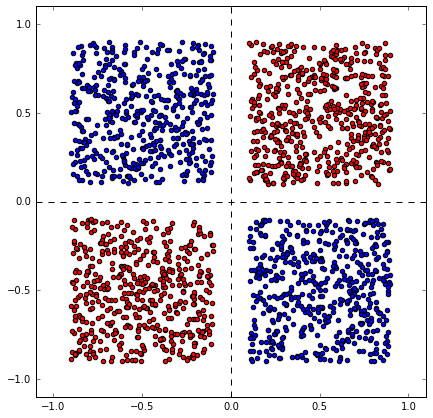

In [4]:
X,y = xor_generator(2000)
xor_plot(X,y)

A continuación se generan los conjuntos de entrenamiento, validación y prueba. De los 2000 datos generados, 1000 son de entrenamiento y 1000 de prueba. Sin embargo de los 1000 de entrenamiento, 20% se ha dejado para la validación durante el entrenamiento de la red.  

**Nota**: Dado que los datos se generaron aleatoriamente, se ha omitido particionar estos conjuntos de forma aleatoria y se ha realizado de forma secuencial.

In [5]:
# training data
X_tr = X[0:800]
y_tr = y[0:800]

# validation data
X_val = X[800:1000]
y_val = y[800:1000]

# testing data
X_ts = X[1000::]
y_ts = y[1000::]

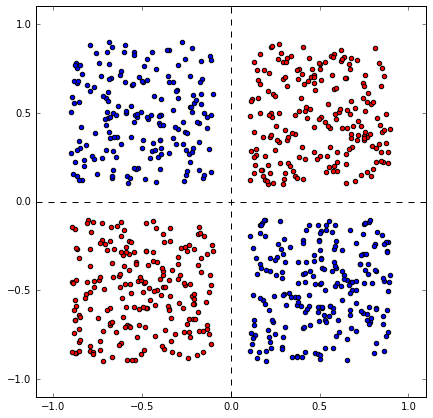

In [6]:
# training data
xor_plot(X_tr, y_tr)

<div id='1b' />
### Parte (b)

En esta primera parte se ha construido una red consistente de una única neurona con las siguientes características:
* Inicialización de pesos distribuida normal.
* Función de activación sigmoidal. Dado que la salida está entre 0 y 1, `keras` utiliza este valor para determinar la correspondiente clase.
* Algoritmo de entrenamiento: [`ADAM`](http://arxiv.org/abs/1412.6980v8). Este es un eficiente y robusto algoritmo estocástico, basado en estimaciones de bajo orden para el momentum. Fue elegido para asegurar la convergencia.  
* _Cross-Entropy_ binaria como función de pérdida: $L(y, \tilde{y}) = - \tilde{y}\log(y) - (1-\tilde{y})\log(1-y)$ ($\tilde{y}$ predicción de $y$). Esto pues esta función de pérdida es una elección estandar para problemas de clasificación binária.
* Número de épocas: 300.

In [7]:
# building the model
model0 = Sequential()
model0.add(Dense(output_dim=1, input_dim=2, activation='sigmoid', init='normal'))
# compiling the model
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist0 = model0.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

La performance obtenida sobre el conjunto de prueba se muestra a continuación:

In [8]:
scores = model0.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 55.400000000000006%


Este resultado nos indíca que un simple neurona tiene un accuracy $\approx$50%, es decir, se comporta logra clasificar bien sólo la mitad de los datos (similar a un clasificador aleatorio). 

Con lo cual se prueba _experimentalmente_ que un sola neurona no resuelve el problema no lineal de XOR. Este es un resultado conocido, dado que, pese a que tiene una activación no lineal, la función de decisión sigue siendo lineal ($w^T x = 0$), y por lo tanto no es posible que logre clasificar data distribuida no linealmente. 

<div id='1c' />
### Parte (c)

Para esta parte se mantiene casi la misma configuración anterior, más unos pequeños ajustes:
* Se agrega una capa oculta con dos neuronas, ambas con función de activación `tanh`.
* Ambas capas tienen inicialización de pesos distribuida normal.

In [9]:
# building the model
model1 = Sequential()
model1.add(Dense(output_dim=2, input_dim=2, activation='tanh', init='normal'))
model1.add(Dense(output_dim=1, init='normal', activation='sigmoid'))
# compiling the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist1 = model1.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

In [10]:
scores = model1.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 91.4%


Como puede notarse el _accuracy_ sobre el conjunto de prueba aumento de manera notoria. Esto nos demuestra _experimentalmente_ que con tan solo agregar dos neuronas en una capa oculta, la red ahora es capaz de aprender fronteras de decisión no lineales. 

A continuación se entrena el mismo modelo anterior, pero con 10 neuronas en la capa oculta.

In [11]:
# building the model
model2 = Sequential()
model2.add(Dense(output_dim=10, input_dim=2, activation='tanh', init='normal'))
model2.add(Dense(output_dim=1, init='normal', activation='sigmoid'))
# compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist2 = model2.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

In [12]:
scores = model2.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 100.0%


El resultado es un ajuste perfecto sobre el test de prueba. Esto va acorde al teorema de aproximación universal; Con una red de 3 capas, y con el número suficiente de neuronas en la capa oculta, es posible aproximar cualquier distribución/función. 

<div id='pred' />
## 2.-  Predicción del precio de una casa

### Funciones de ayuda para esta sección.

In [13]:
"""
Input:
> hist - history object from model.fit() method
Output:
> plot of training and validation loss vs epochs
"""
def history_plot(hist, title=None):
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax.set_xticks(np.linspace(1,301,20))
    ax.set_yticks(np.linspace(0,1,10))
    plt.xlim(0,301)
    plt.ylim(0,1)
    if title is None:
        plt.title('Mean Squared Training and Validation Error')
    else: plt.title(title)
    plt.plot(range(1,301), hist.history['loss'], 'bo-', label='MSE train')
    plt.plot(range(1,301), hist.history['val_loss'], 'go-', label='MSE validation')
    plt.legend(loc=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()   

<div id='2a' />
### Parte (a)

La línea 4 del siguiente código se encarga de descargar el dataset correspondiente, leerlo (con valores separados por coma) e introducirlo dentro de un _data frame_ de `pandas` con las etiquetas correspondientes para cada característica. 

La línea 6 se encarga de generar los conjuntos de entrenamiento y validación. Sobre el _data frame_ anterior, se realiza una separación de 75% para entrenamiento, y 25% para prueba. Como resultado se obtienen los _data frame_ de entrenamiento y prueba respectivos.

```python
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'

df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
```

In [14]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',', header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])

from sklearn.cross_validation import train_test_split
df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)

<div id='2b' />
### Parte (b)

Como se puede ver de las celdas que siguen, el _dataset_ se caracteriza por lo siguiente:
* 506 ejemplos en total
* 13 características (hay 14 variables, pero una corresponde a la de salida).
* Las características estan compuestas en su mayor parte por variables continuas reales y positivas. Sin embargo también hay variables discretas como `ZN`, `CHAS` (categórica), `RAD`, `TAX` y `PTRATIO`.

In [15]:
# mostrando algunas características del dataset contenido en el frame
print('Numero de ejemplos: {0}'.format(df.shape[0]))
print('Numero de características: {0}'.format(df.shape[1]))

Numero de ejemplos: 506
Numero de características: 14


In [16]:
print(df.info)

<bound method DataFrame.info of          CRIM  ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
0     0.00632  18   2.31     0  0.538  6.575   65.2  4.0900    1  296   
1     0.02731   0   7.07     0  0.469  6.421   78.9  4.9671    2  242   
2     0.02729   0   7.07     0  0.469  7.185   61.1  4.9671    2  242   
3     0.03237   0   2.18     0  0.458  6.998   45.8  6.0622    3  222   
4     0.06905   0   2.18     0  0.458  7.147   54.2  6.0622    3  222   
5     0.02985   0   2.18     0  0.458  6.430   58.7  6.0622    3  222   
6     0.08829  12   7.87     0  0.524  6.012   66.6  5.5605    5  311   
7     0.14455  12   7.87     0  0.524  6.172   96.1  5.9505    5  311   
8     0.21124  12   7.87     0  0.524  5.631  100.0  6.0821    5  311   
9     0.17004  12   7.87     0  0.524  6.004   85.9  6.5921    5  311   
10    0.22489  12   7.87     0  0.524  6.377   94.3  6.3467    5  311   
11    0.11747  12   7.87     0  0.524  6.009   82.9  6.2267    5  311   
12    0.09378  12  

In [17]:
df.describe

<bound method NDFrame.describe of          CRIM  ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
0     0.00632  18   2.31     0  0.538  6.575   65.2  4.0900    1  296   
1     0.02731   0   7.07     0  0.469  6.421   78.9  4.9671    2  242   
2     0.02729   0   7.07     0  0.469  7.185   61.1  4.9671    2  242   
3     0.03237   0   2.18     0  0.458  6.998   45.8  6.0622    3  222   
4     0.06905   0   2.18     0  0.458  7.147   54.2  6.0622    3  222   
5     0.02985   0   2.18     0  0.458  6.430   58.7  6.0622    3  222   
6     0.08829  12   7.87     0  0.524  6.012   66.6  5.5605    5  311   
7     0.14455  12   7.87     0  0.524  6.172   96.1  5.9505    5  311   
8     0.21124  12   7.87     0  0.524  5.631  100.0  6.0821    5  311   
9     0.17004  12   7.87     0  0.524  6.004   85.9  6.5921    5  311   
10    0.22489  12   7.87     0  0.524  6.377   94.3  6.3467    5  311   
11    0.11747  12   7.87     0  0.524  6.009   82.9  6.2267    5  311   
12    0.09378  12

<div id='2c' />
### Parte (c)

Si bien en problemas de regresión, los modelos obtenidos al escalar los datos son todos equivalentes, con modificaciones en el tamaño de los pesos asociado a cada característica, en el caso particular de las ANN ciertas consideraciones numéricas/prácticas para los cuales la estandarización/normalización ayudan en gran medida.

* Al normalizar las características, el espacio de búsqueda de los pesos $\mathbf{W}$ se vuelve más uniforme, y los algoritmos de optimización (SGD por ejemplo) lograr recorrerlo de mejor manera, sin estancarse en óptimos locales.
* De acuerdo a la regla de actualización para los pesos $W$, si todas las unidades de entrada tienen valores positivos (que es precisamente nuestro caso!), en cada iteración las actualizaciones que a los pesos serán del mismo signo. Como resultado se obtiene un proceso de aprendizaje lento, y que en la mayoría de los casos no logra conveger.

**Nota:** Para tener resultados consistentes, se ha ocupa la misma transformación sobre datos de entrenamiento y prueba.

In [18]:
# scaling for training set
scaler = StandardScaler().fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
y_train_scaled = df_train_scaled.pop('MEDV')
X_train_scaled = df_train_scaled

In [19]:
# the same but for testing set
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
y_test_scaled = df_test_scaled.pop('MEDV')
X_test_scaled = df_test_scaled

<div id='2d' />
### Parte (d)

In [20]:
# building the model
model = Sequential()
model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))
# compiling the model
model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')

In [21]:
# fitting the model
hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 1.0321 - val_loss: 0.9408
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.9811 - val_loss: 0.9186
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.9481 - val_loss: 0.9296
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.9551 - val_loss: 0.8748
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.9044 - val_loss: 0.8508
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.8815 - val_loss: 0.9043
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.8268 - val_loss: 0.8510
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.8159 - val_loss: 0.8136
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.7836 - val_loss: 0.7513
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.7126 - val_loss: 0.7272
Epoch 11/300
379/379 [===========

En primer lugar es importante mencionar que con _learning rate_ `lr`=0.2 (tal el trabajo solicitaba) los pesos de la red divergen en la primera época. Por lo tanto _experimentalmente_ se cambió al valor `lr`=0.01 para el cuál si logra converger. 

Los resultados se muestran a continuación:

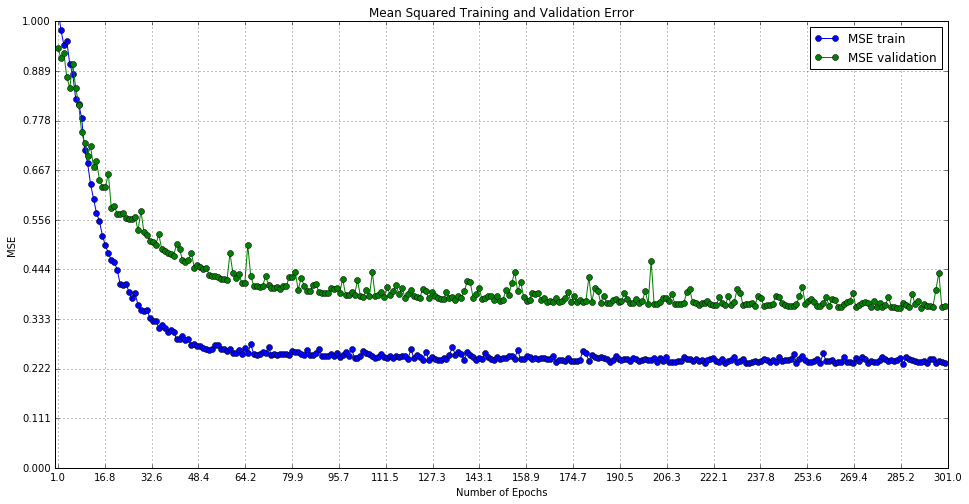

In [22]:
history_plot(hist)

Como es de esperar, a medida que el número de épocas aumentan tanto el error de entrenamiento como el de validación disminuyen, siendo siempre el error de entrenamiente inferior al de validación, puesto que la red tiende a sobreajustar los datos con los que se le entrena. 

Es importante notar que pasadas las 100 épocas no hay grandes mejoras en ambos errores.

<div id='2e' />
### Parte (e)

Se repite el procedimiento anterior (con mismo `lr`=0.01), pero ahora con función de activación `relu` para la capa oculta.

In [23]:
# building the model
model = Sequential()
model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))
# compiling the model
model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')

In [24]:
# fitting the model
hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 0.9668 - val_loss: 0.8750
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.8431 - val_loss: 0.7935
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.7325 - val_loss: 0.7222
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.6308 - val_loss: 0.6623
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.5435 - val_loss: 0.6150
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.4716 - val_loss: 0.5788
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.4146 - val_loss: 0.5493
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.3687 - val_loss: 0.5235
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.3320 - val_loss: 0.5013
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.3022 - val_loss: 0.4798
Epoch 11/300
379/379 [===========

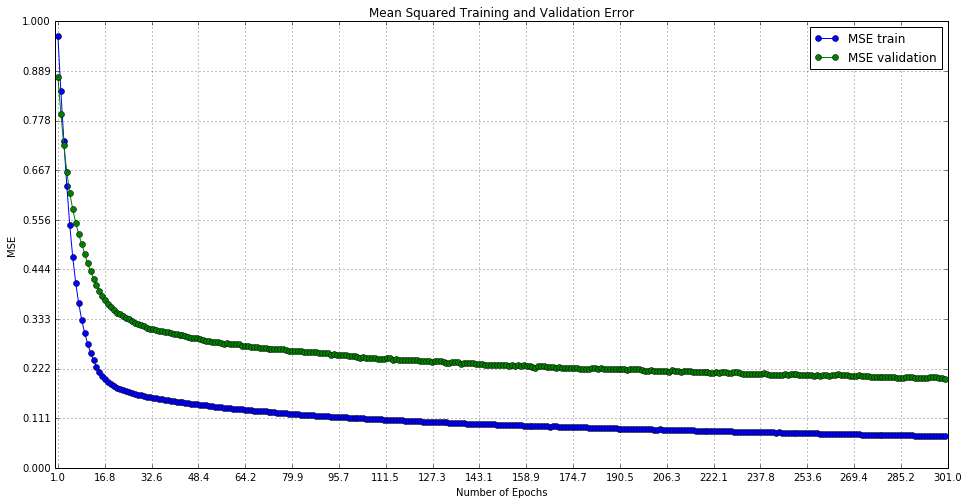

In [25]:
history_plot(hist)

El resultado anterior muestra una gran mejora respecto de lo obtenido con funciones de activación sigmoidales. La siguiente tabla resume los resultados finales para ambos casos.

|            | `sigmoid` | `relu`   |
|------------|---------|--------|
| Training   | 0.2377  | 0.0683 |
| Validation | 0.3584  | 0.2022 |

Adicionalmente como se aprecia de los gráficos, la convergencia es mucho más _uniforme_ en la caso de `relu`, esto es, se nota una tendencia casi monotonamente decreciente. Esto puede deberse a la que los patrones de activación en la red son más _sparse_, y por tanto menos susceptible a datos _outliers_.

<div id='2f' />
### Parte (f)

A continuación se repite el modelo en (d), pero con 20 diferentes _learning rates_. El `lr` más alto ocupado es 0.03, que corresponde al valor más alto (encontrado _experimentalmente_) para el cual la red converge.

In [26]:
n_lr = 20
learning_rate = np.linspace(0, 0.03, n_lr+1)[1::]
hist_list = list()

for i in range(n_lr):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=learning_rate[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

En los siguientes gráficos se muestra la evolución del error de entrenamiento y validación, para los modelos entrenados con los distintos _learning rates_. (No fueron puestos todos juntos, por motivos de visualización).

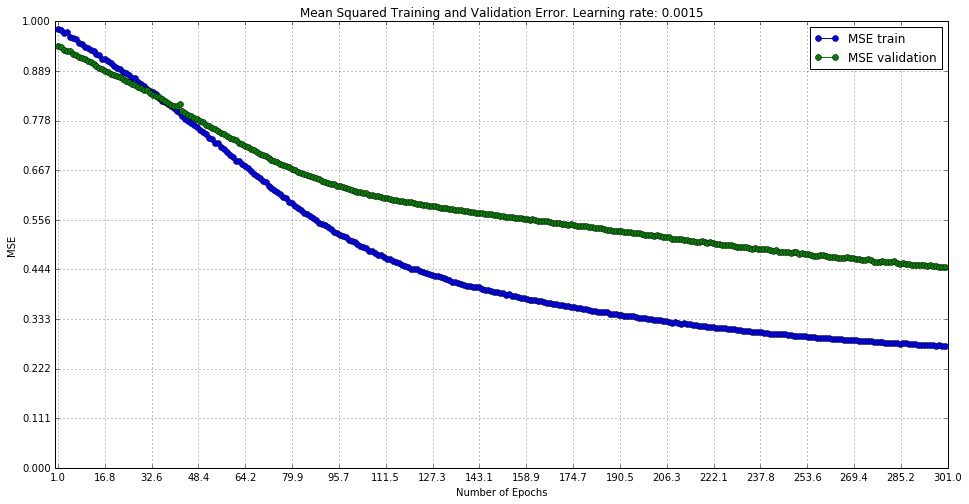

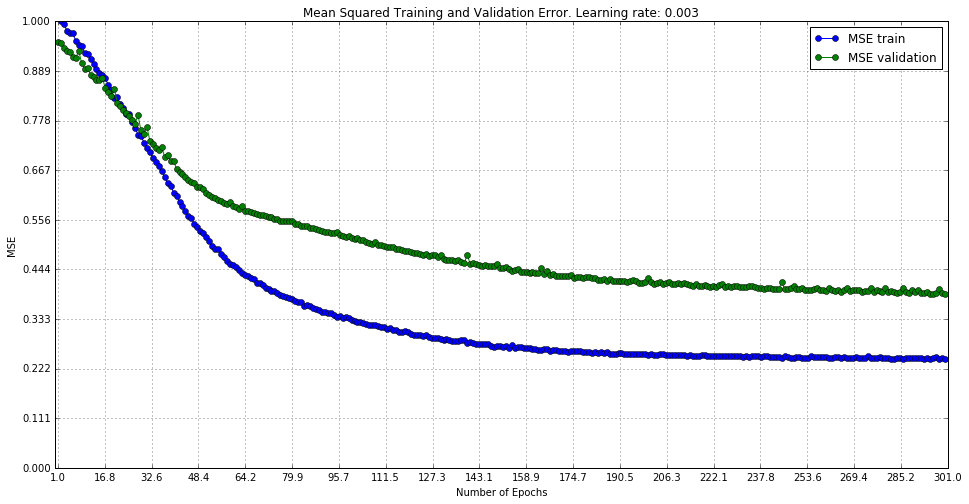

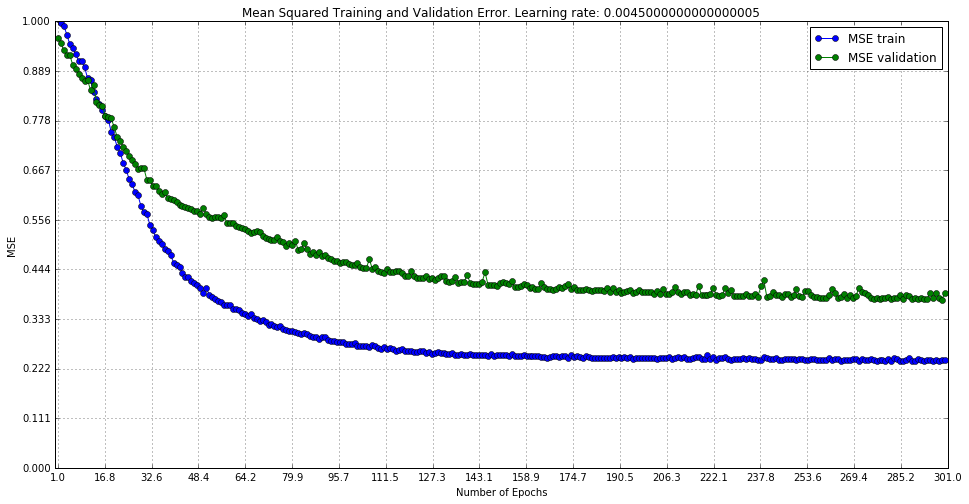

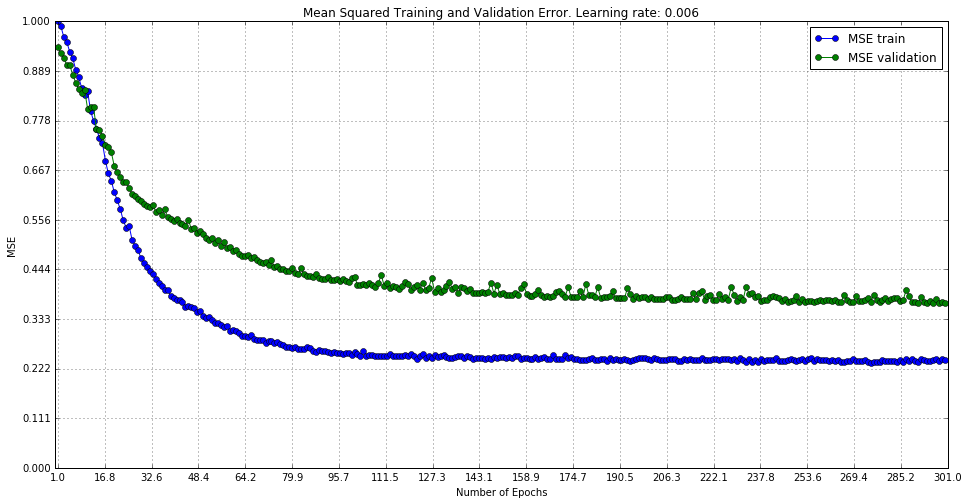

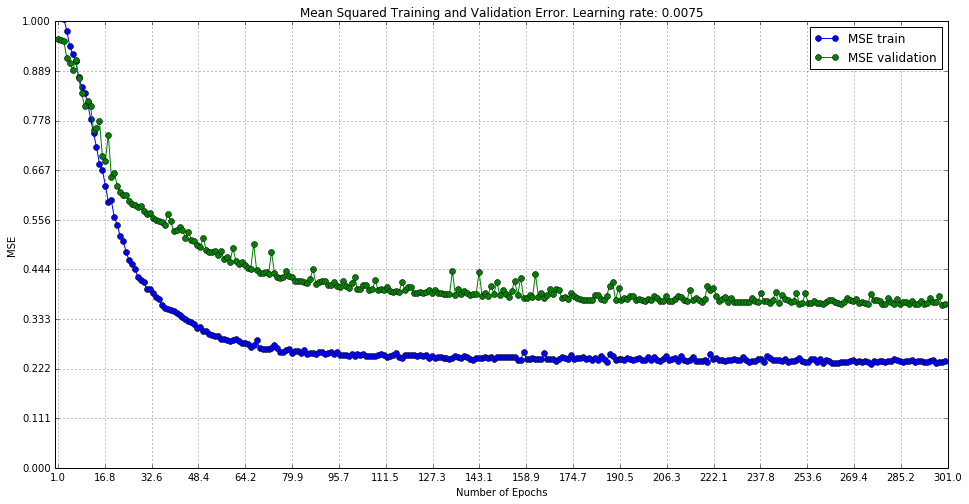

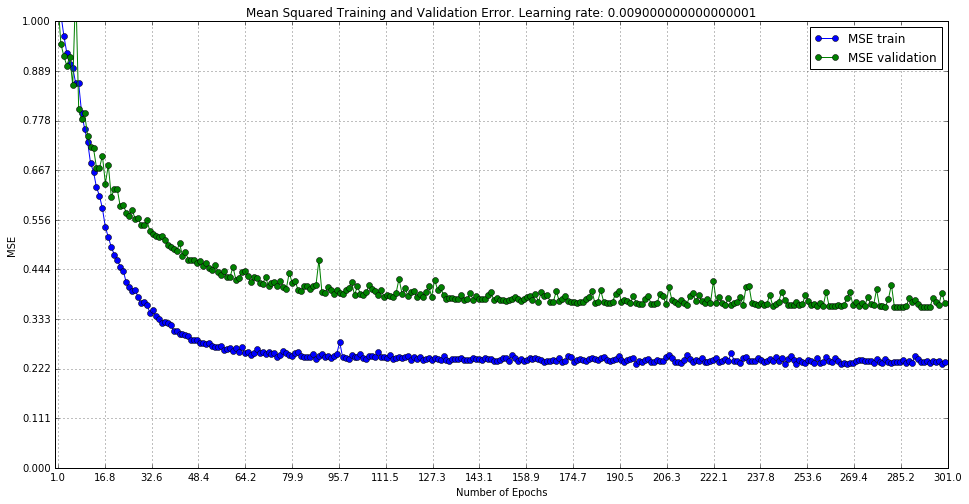

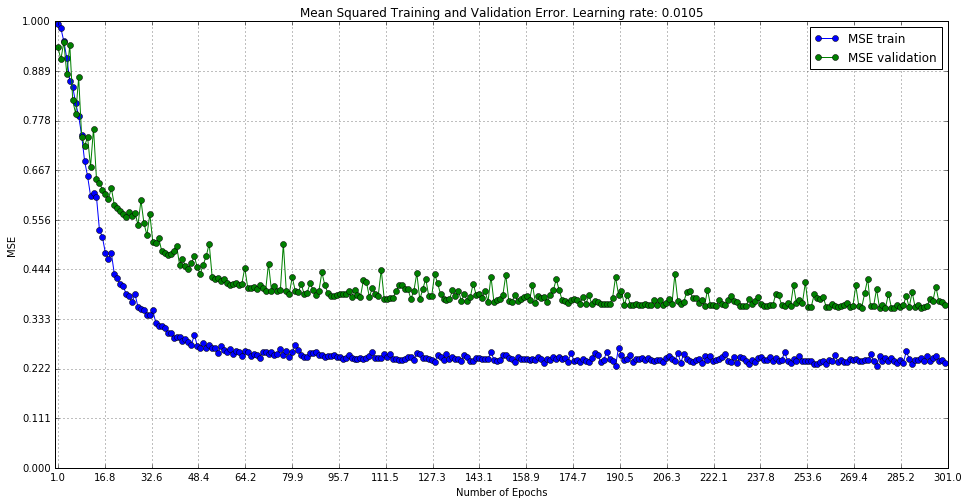

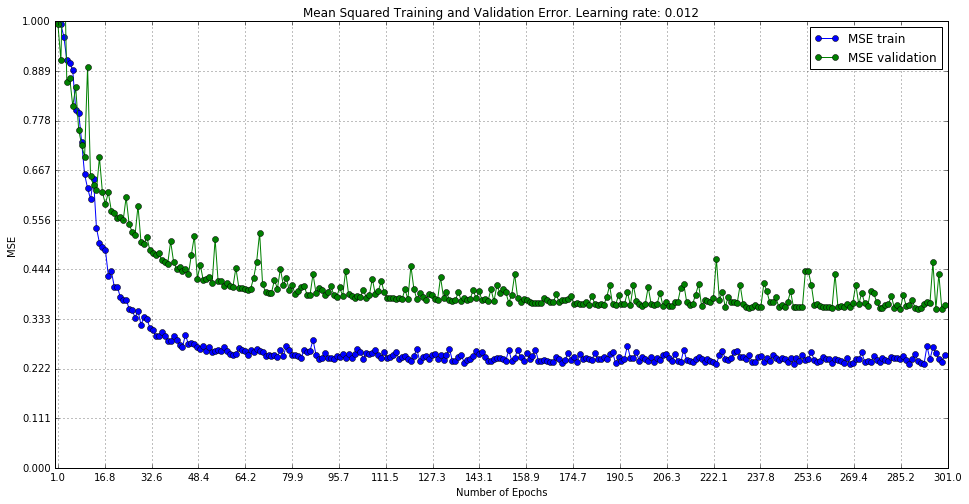

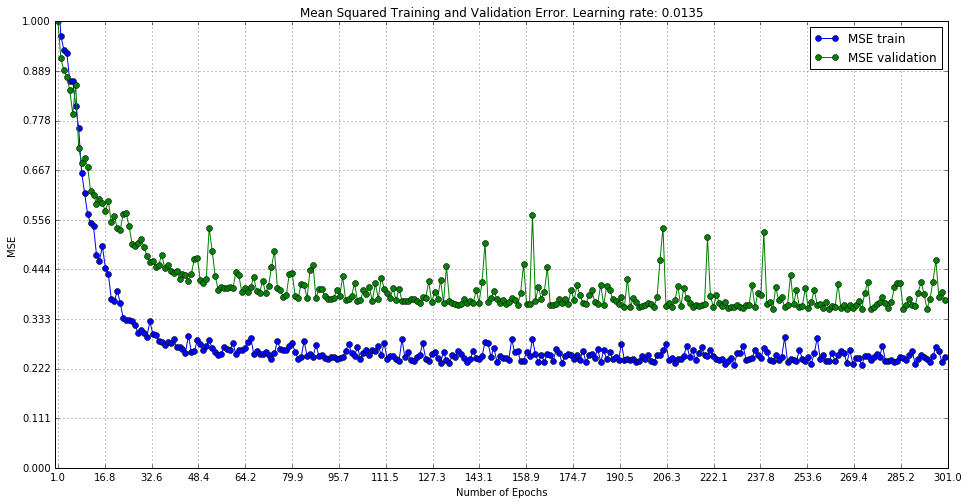

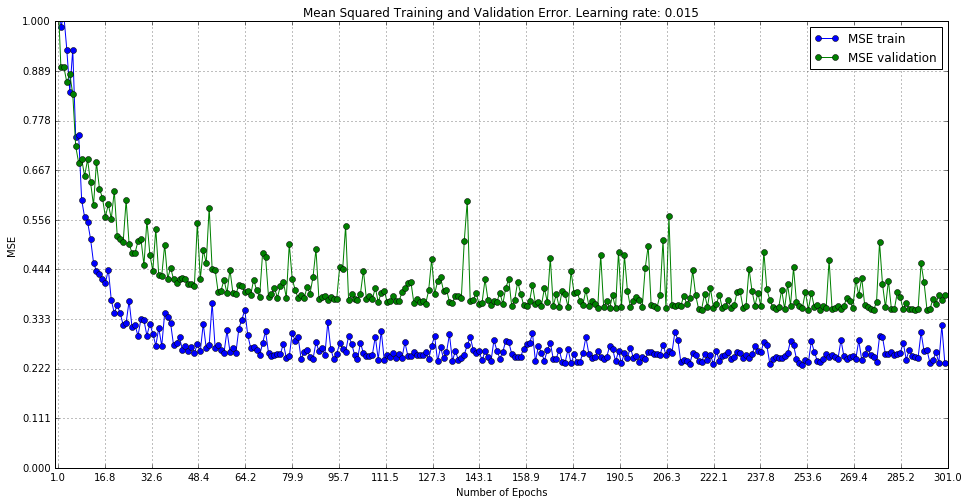

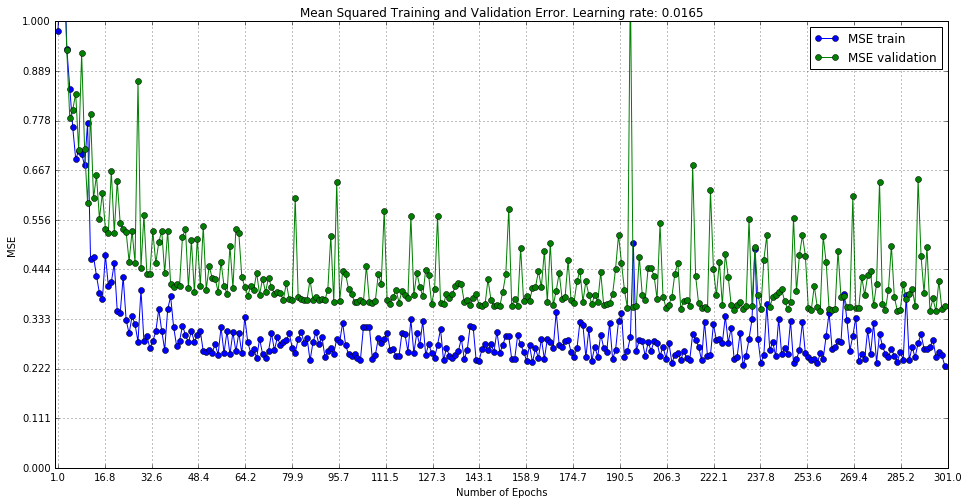

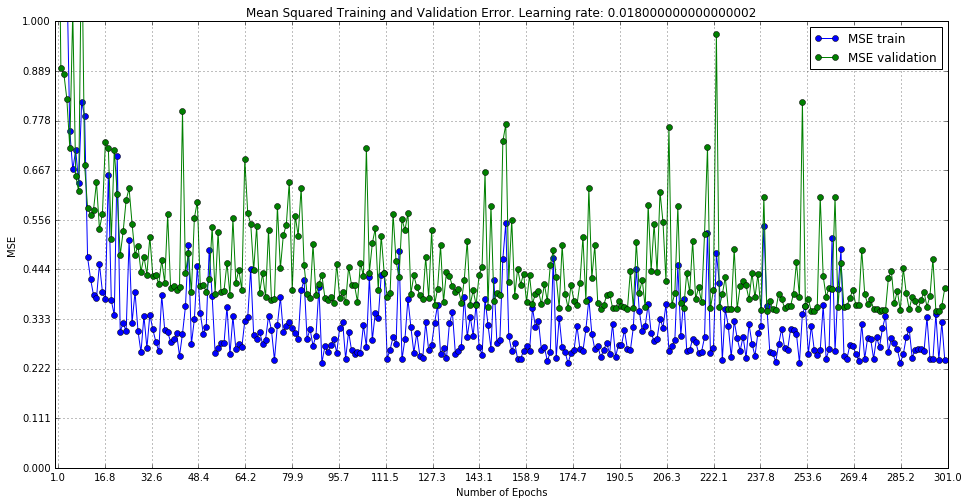

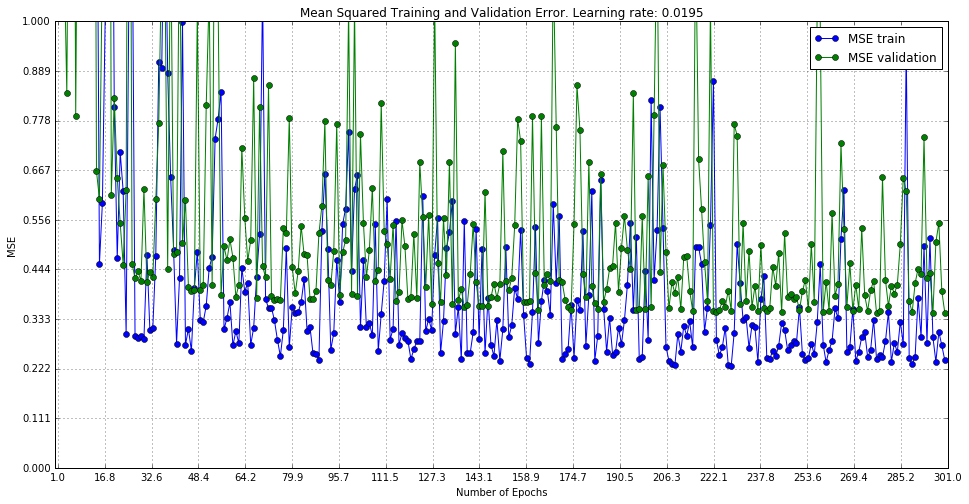

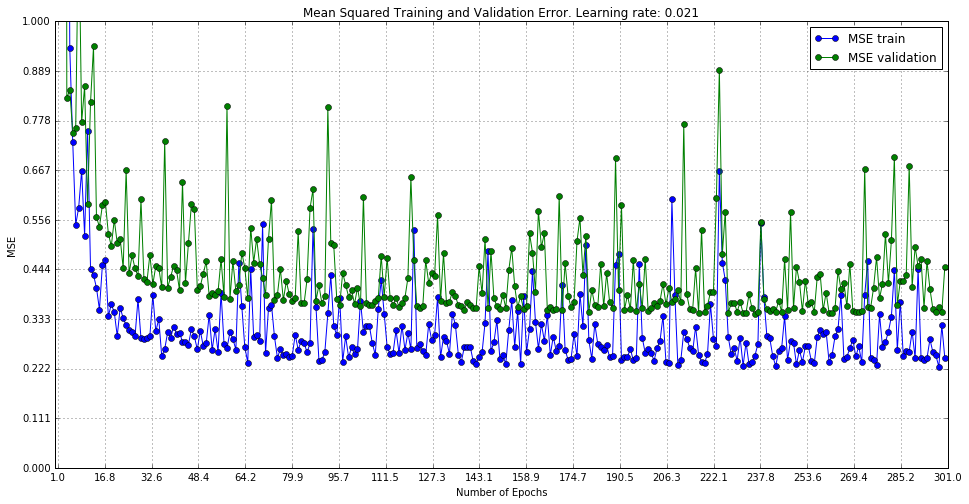

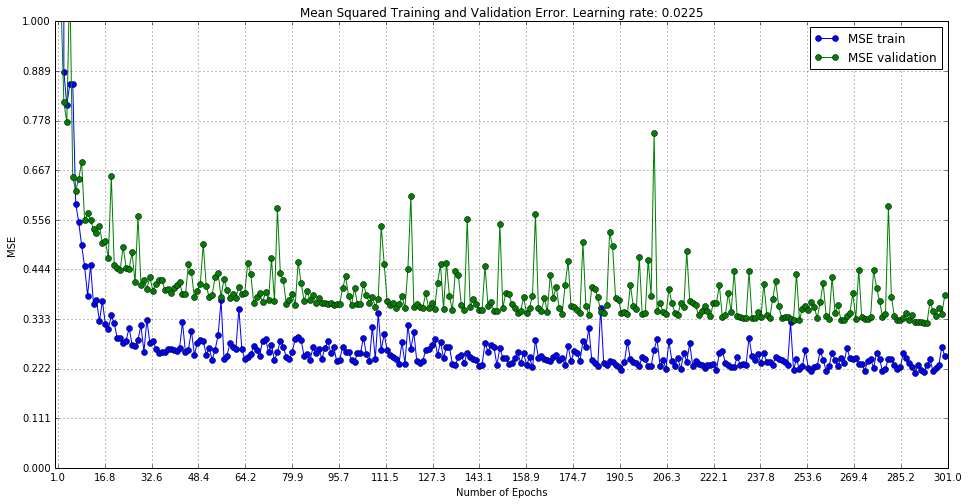

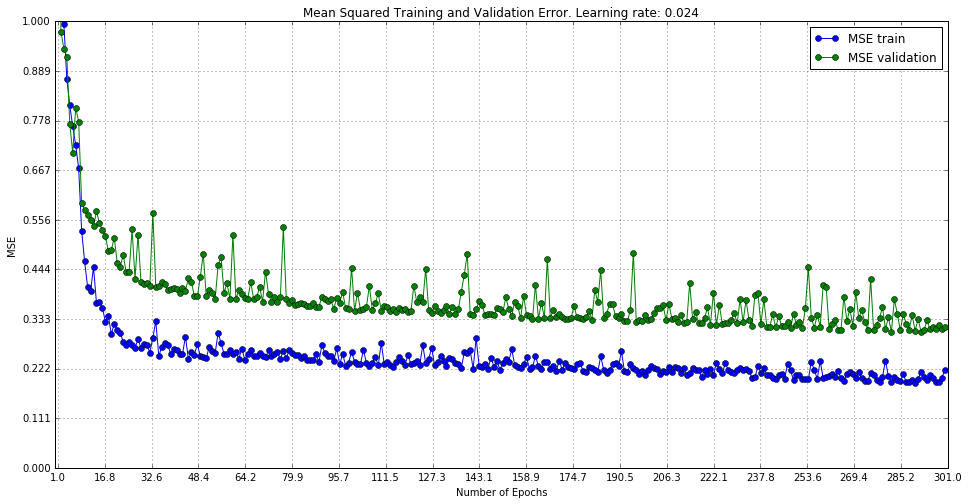

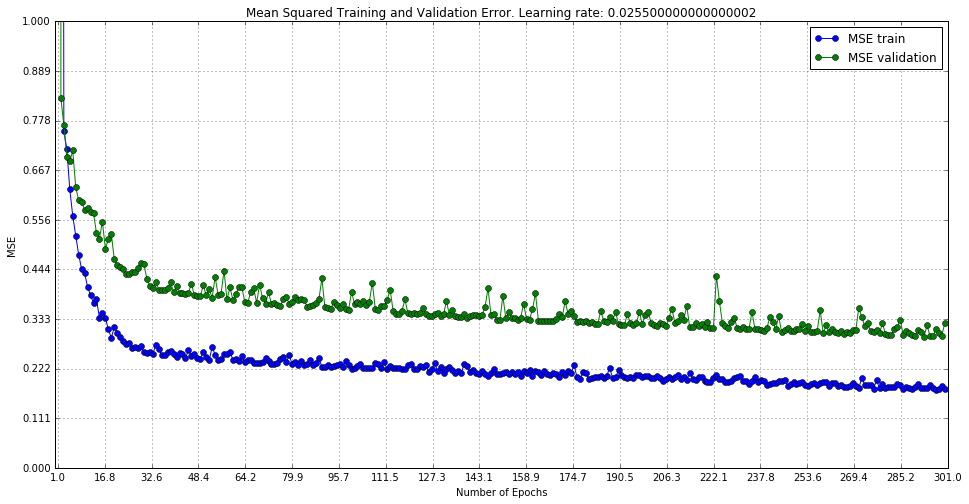

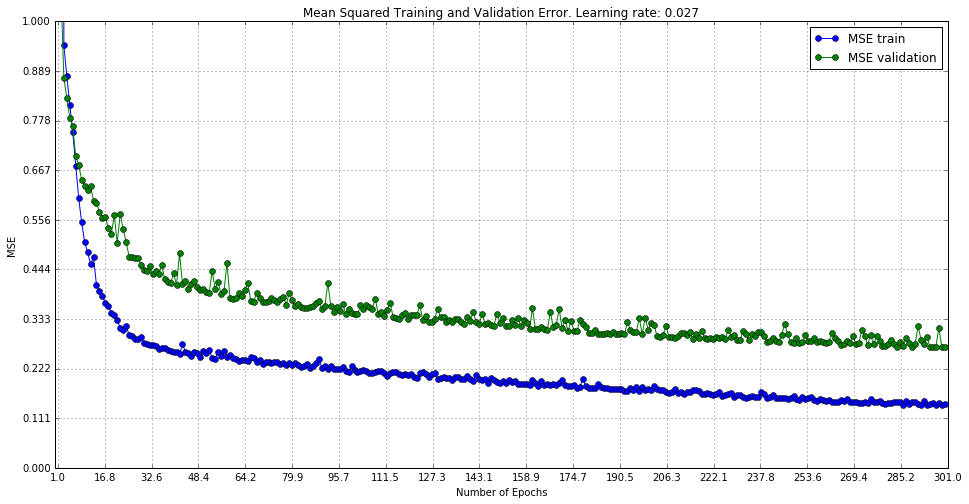

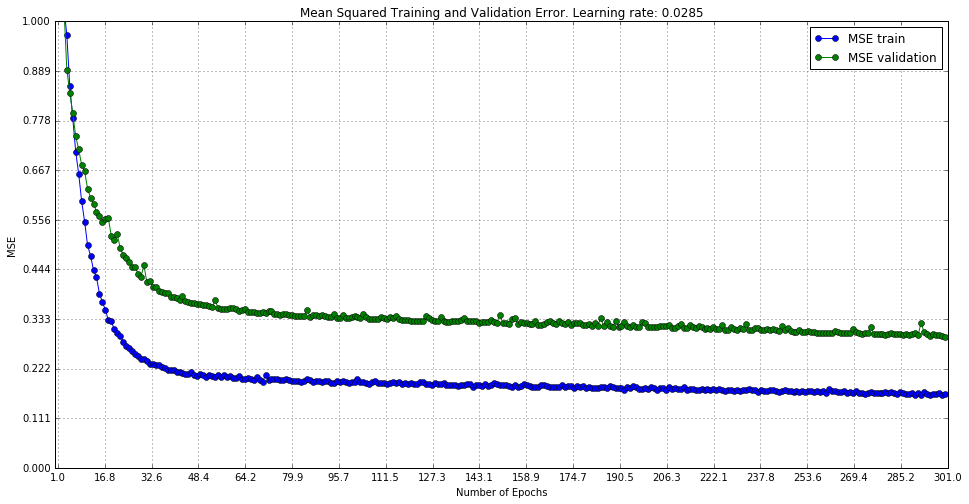

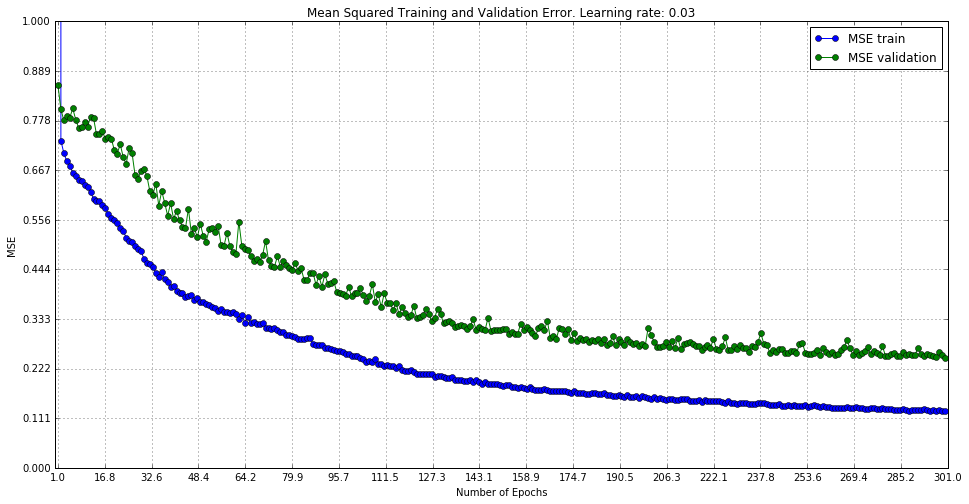

In [27]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Learning rate: {0}'.format(learning_rate[i])
    history_plot(hist, title)

De los gráficos anteriores varias cosas se pueden notar:
* Para learning rates muy pequeños los errores de la red convergen de modo uniforme, sin embargo el error disminuye poco y faltan épocas para disminuirlo aun más (convergecia lenta).
* Existe un rango intermedio de _learning rates_ $\in [0.015, 0.024]$ para el cuál el comporatamiento de los errores varía mucho. Se puede concluir que para tal rango de valores el algoritmo de optimización no puede explorar bien el espacio de pesos $\mathbf{W}$.
* Para los valores más altos del _learning rate_ la red converge a los menores errores posibles (con tal 300 épocas). Se verifica la convergencia rápida.

El siguiente gráfico muestra los errores de entrenamiento y validación finales para cada learning rate, y apoya los puntos explicado anteriormente. 

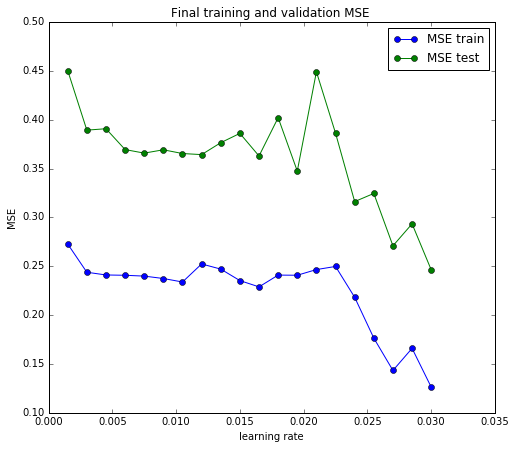

In [28]:
loss = list()
val_loss = list()
for hist in hist_list:
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
# plot
plt.figure(figsize=(8,7))
plt.title('Final training and validation MSE ')
plt.plot(learning_rate, loss, 'bo-', label='MSE train')
plt.plot(learning_rate, val_loss, 'go-', label='MSE test')
plt.xlabel('learning rate')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

<div id='2g' />
### Parte (g)

#### 5-Fold Cross Validation

Se realiza en primer lugar el proceso de entrenamiento con _5-Fold Cross Validation_. Para ello se sigue el procedimiento estandar, se separa el conjunto de entranmiento en 5 partes iguales, y en cada iteración se entrena con 4 de las 5 partes, validando en la parte restante.

In [29]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = KFold(len(Xm), 5)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val], verbose=0)
    cvscores.append(scores)
mse_cv5 = np.mean(cvscores)
print('MSE para 5-Fold cross validation: {0}'.format(mse_cv5))

MSE para 5-Fold cross validation: 0.26487789851845356


#### 10-Fold Cross Validation

Se repite el mismo proceso anterior, pero ahora para _10-Fold Cross Validation_.

In [30]:
kfold = KFold(len(Xm), 10)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val], verbose=0)
    cvscores.append(scores)
mse_cv10 = np.mean(cvscores)
print('MSE para 5-Fold cross validation: {0}'.format(mse_cv10))

MSE para 5-Fold cross validation: 0.27739943446297394


La siguiente tabla resume los resultados obtenidos con cross validation, y los resultados del modelo original, esto es, entrenados con todos los datos de entrenamiento.

|            | MSE |
|------------|-----|
| 5-Fold CV  |  0.266956902278   |
| 10-Fold CV |  0.262019757892   |
| Original   |  0.3584   |

La estimación del error para ambos procesos de CV son muy similares. Lo que es destacable notar, es que ambos obtienen una estimación de MSE menor que el error original obtenido entrenando sobre todos los datos de entrenamiento. Esto puede entenderse como una expresión del **overfitting**: Al tener más datos para entrenar, produce un modelo sobreajustado con baja capacidad de generalización. En este sentido CV sobrelleva de mejor modo tal problema.   

<div id='2h' />
### Parte (h)

En la presente sección se utiliza el modelo en (d), pero agregando _progressive decay_ para el learning rate. La regla de actualización es la siguiente: `LearningRate = LearningRate * 1/(1 + decay * epoch)`.

In [31]:
n_decay = 10
learning_decay = np.logspace(-6, 0, n_decay)
hist_list = list()

for i in range(n_decay):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.03, decay=learning_decay[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

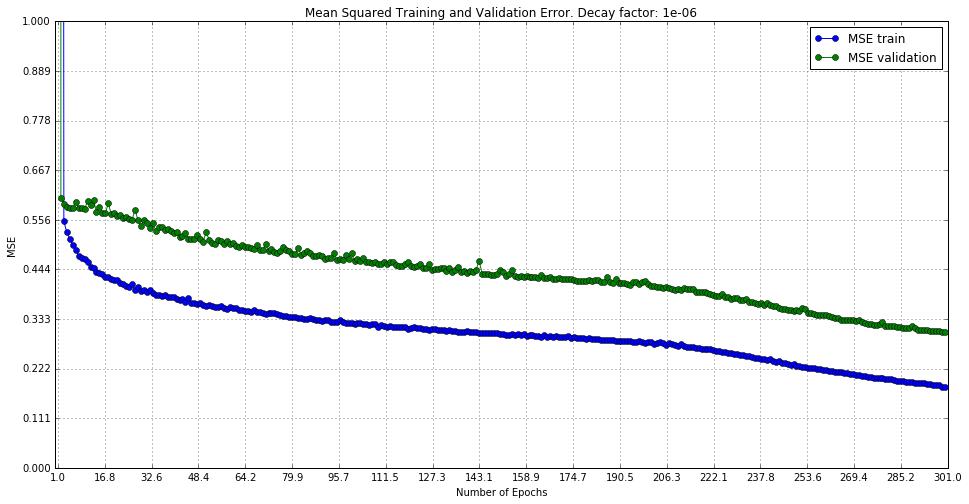

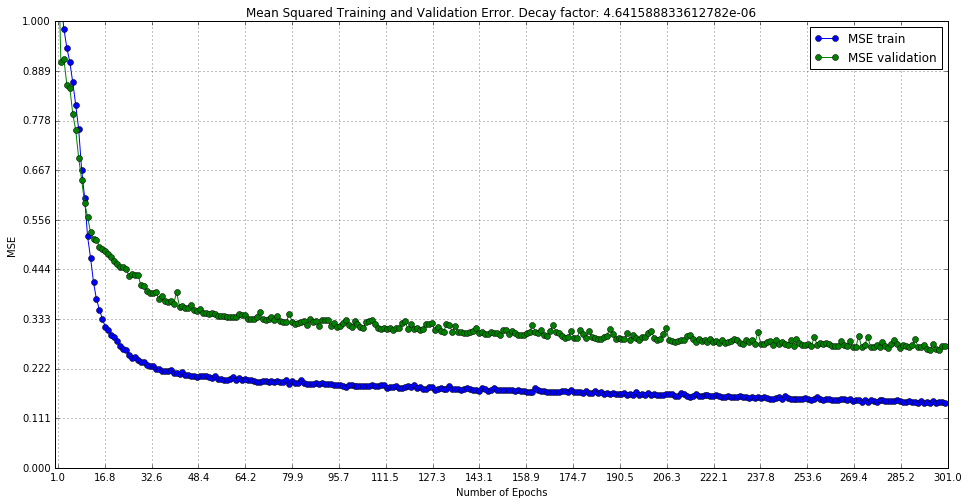

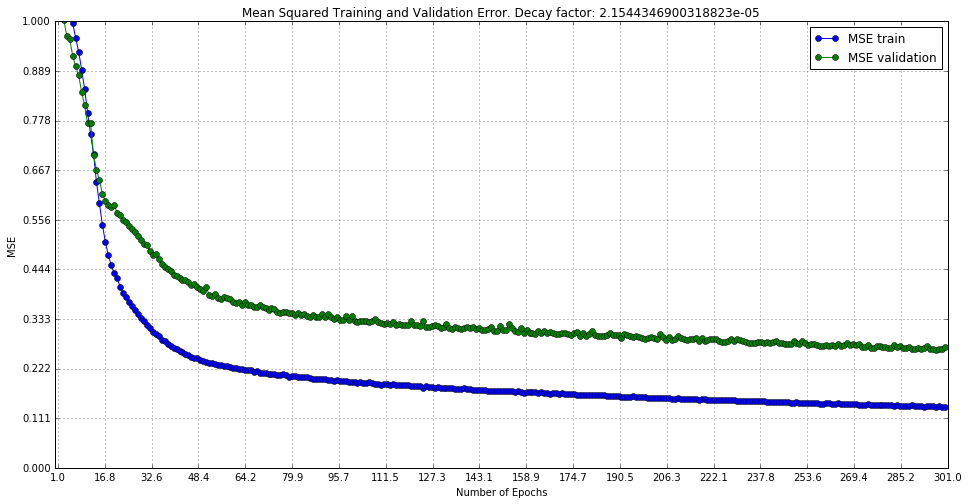

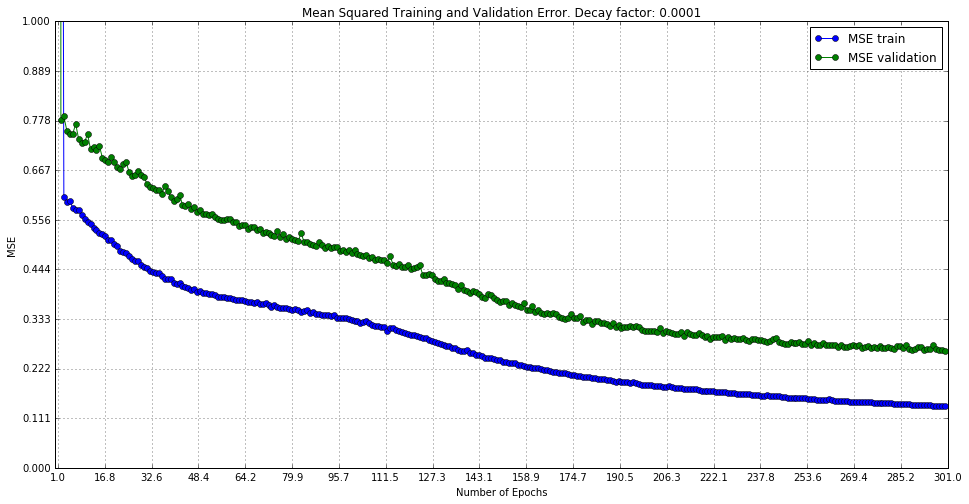

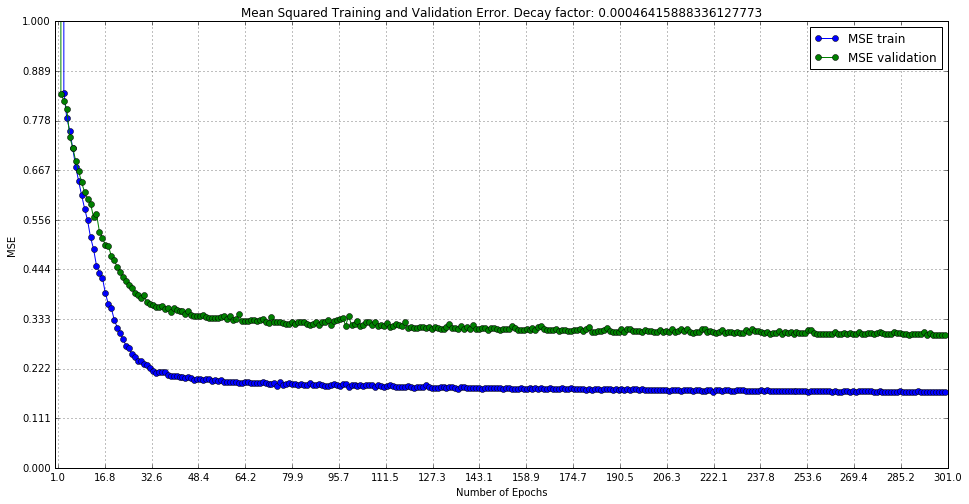

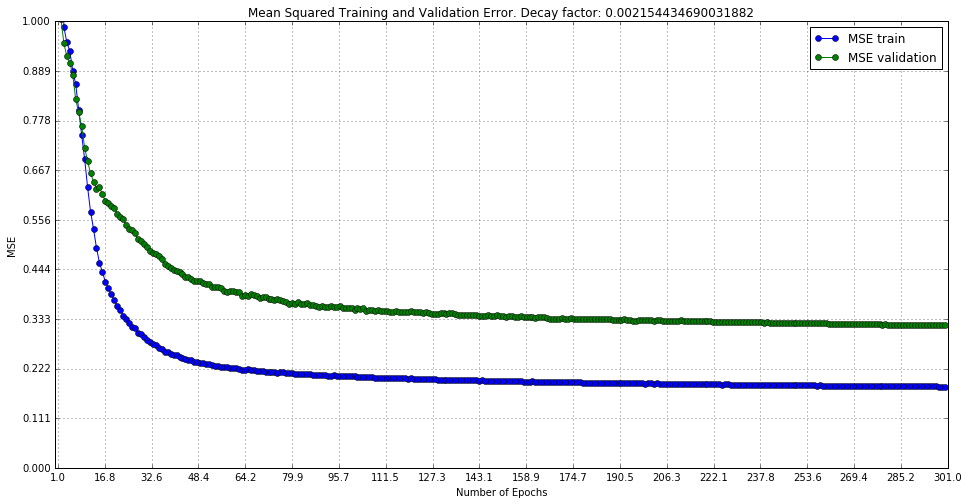

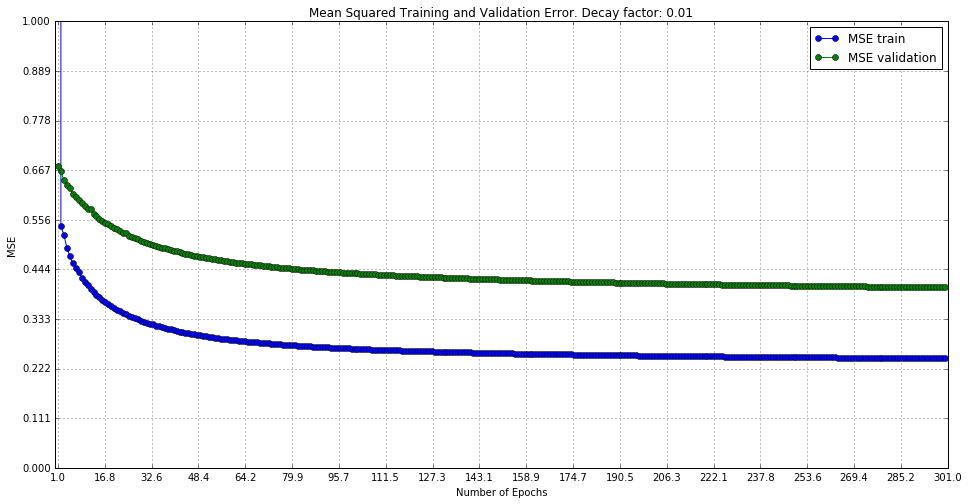

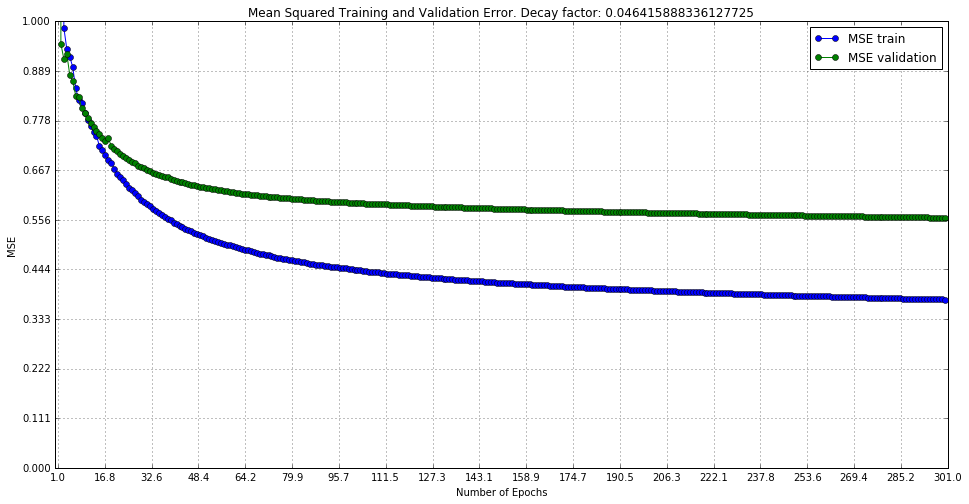

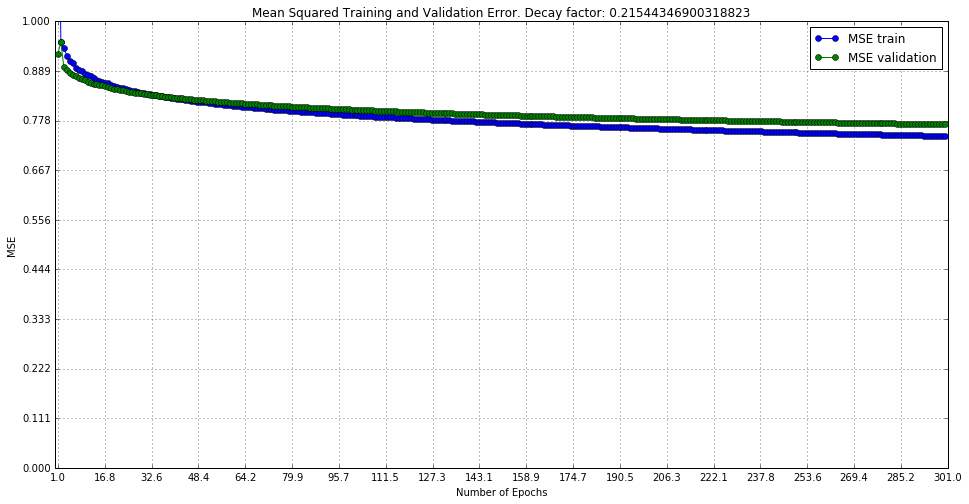

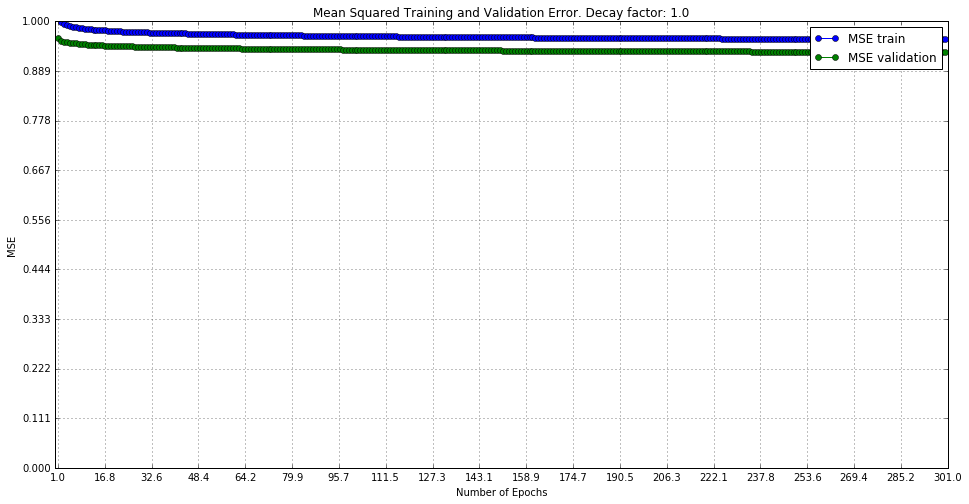

In [32]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Decay factor: {0}'.format(learning_decay[i])
    history_plot(hist, title)

A partir de los gráficos anteriores se puede concluir lo siguiente:
* Para valores de `decay` pequeños, el _learning rate_ prácticamente no cambia y por tanto se obtienen resultados casi iguales a los obtenidos con _learning rate_ estático.
* Para valores de `decay` intermedios, el algoritmo de optimización (SGD) alcanza mejores óptimos locales, es decir, lograr recorrer mejor el espacio de pesos $\mathbf{W}$.
* Para valores de `decay` muy altos, el _learning rate_ disminuye muy drásticamente, y por tanto se genera una convergencia excesivamente lenta en el error.

El siguiente gráfico soporta los puntos anteriores:

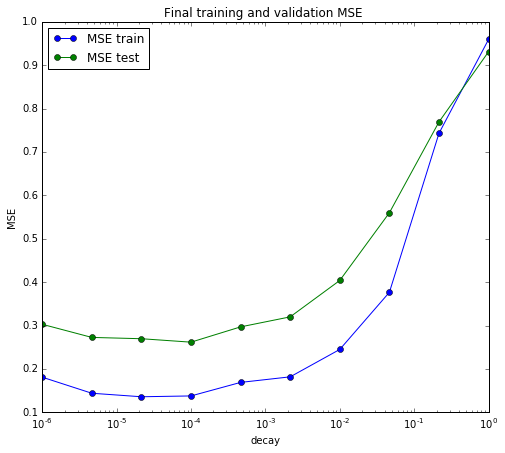

In [34]:
loss = list()
val_loss = list()
for hist in hist_list:
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
# plot
plt.figure(figsize=(8,7))
plt.title('Final training and validation MSE ')
plt.semilogx(learning_decay, loss, 'bo-', label='MSE train')
plt.semilogx(learning_decay, val_loss, 'go-', label='MSE test')
plt.xlabel('decay')
plt.ylabel('MSE')
plt.legend(loc=2)
plt.show()

<div id='2i' />
### Parte (i)

En la presente sección se utiliza el mismo modelo que en (d), pero ahora agregando `momentum` al algoritmo de optimización (SGD), motivados por la idea de mejorar el proceso de convergencia. La regla de actualización que ocupara `keras` para SGD con `momentum` es como sigue:

\begin{align}
v(t) &= \mu \cdot v(t-1) - \eta \cdot \nabla_{\theta}J(\theta) \\
w(t+1) &= w(t) + v(t)
\end{align}

la idea de este método es mantener un historia de los gradiente anteriores, almacenados en una variable de _momentum_, de modo que el algoritmo de optimización no oscile tanto en torno a los óptimo locales, esto gracias al _momentum_ acumulado de las iteraciones anteriores. 

In [35]:
n_momentum = 10
momentum = np.linspace(0., 0.2, n_momentum+1)[1::]
hist_list = list()

for i in range(n_momentum):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.03, decay=momentum[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

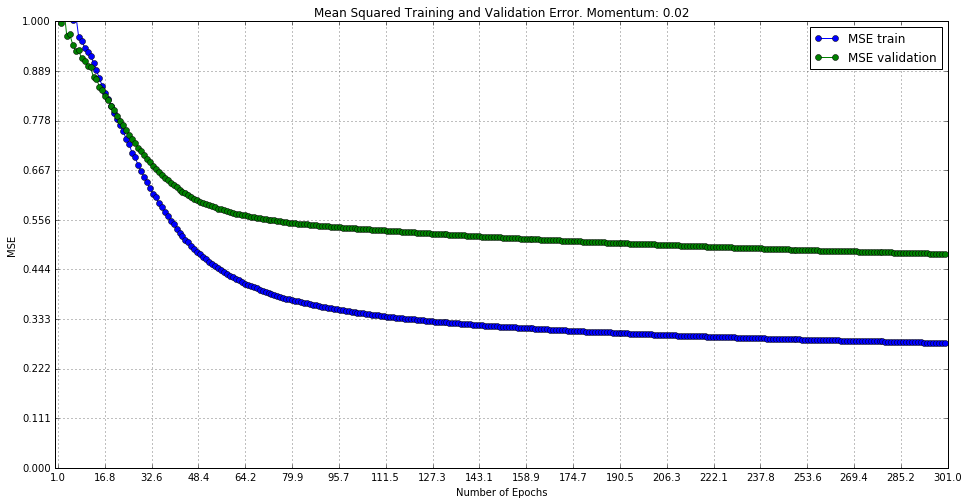

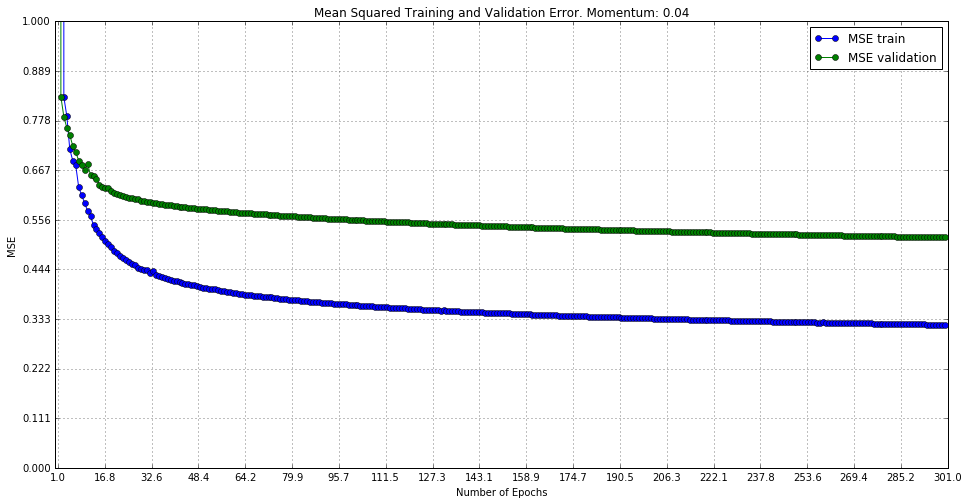

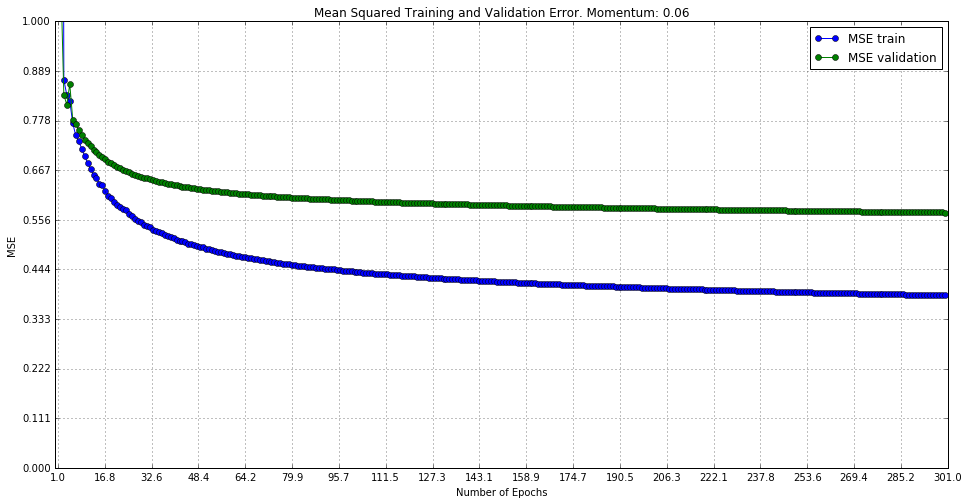

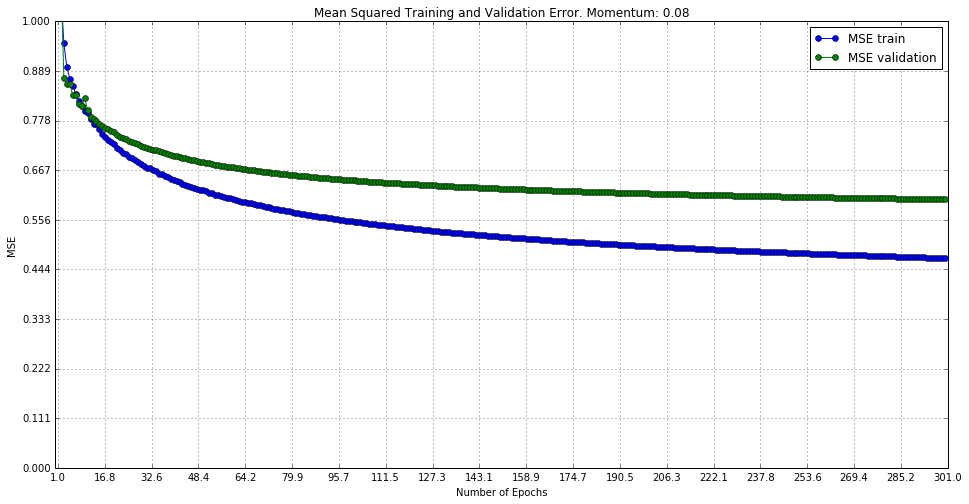

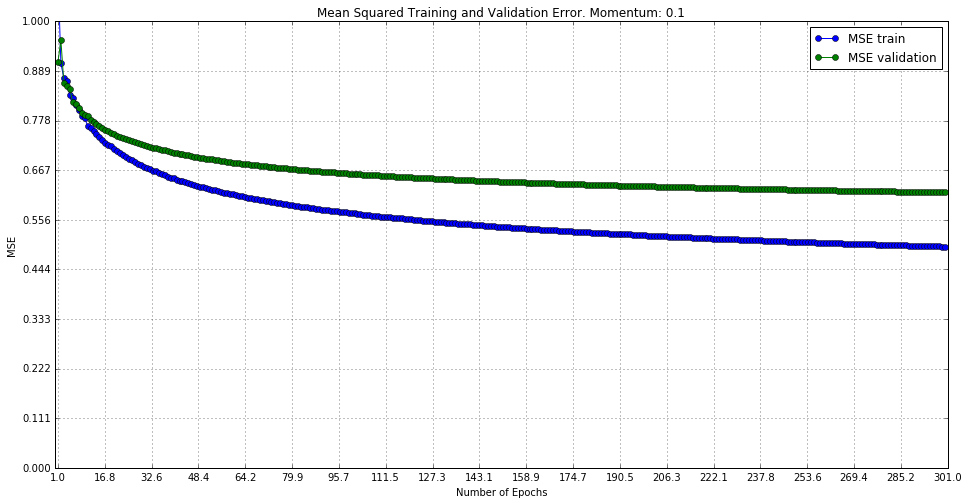

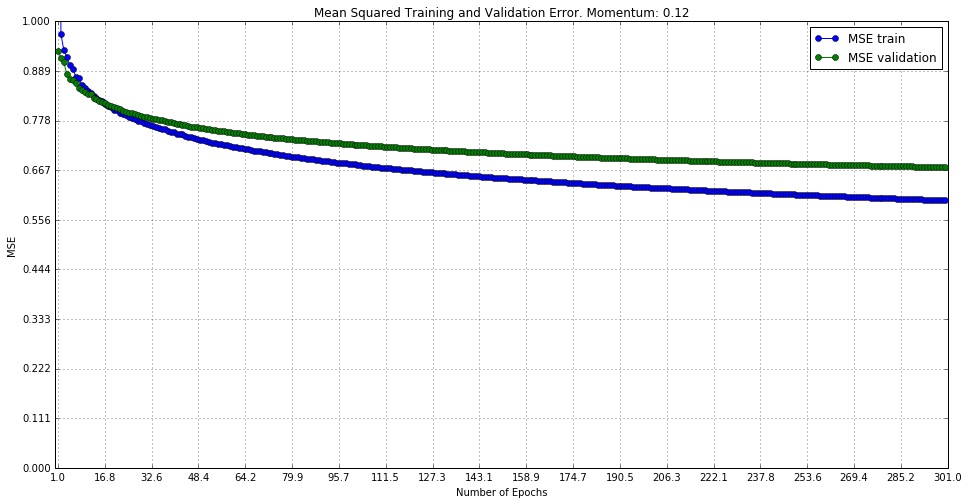

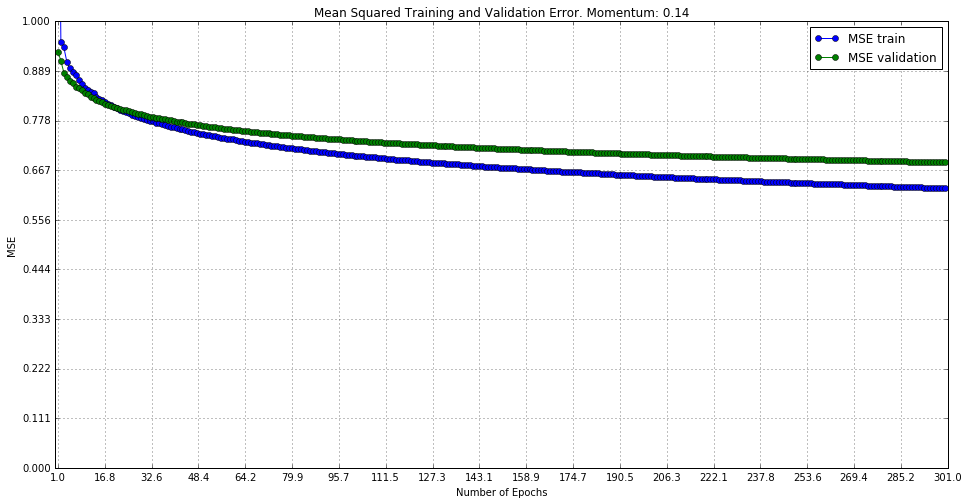

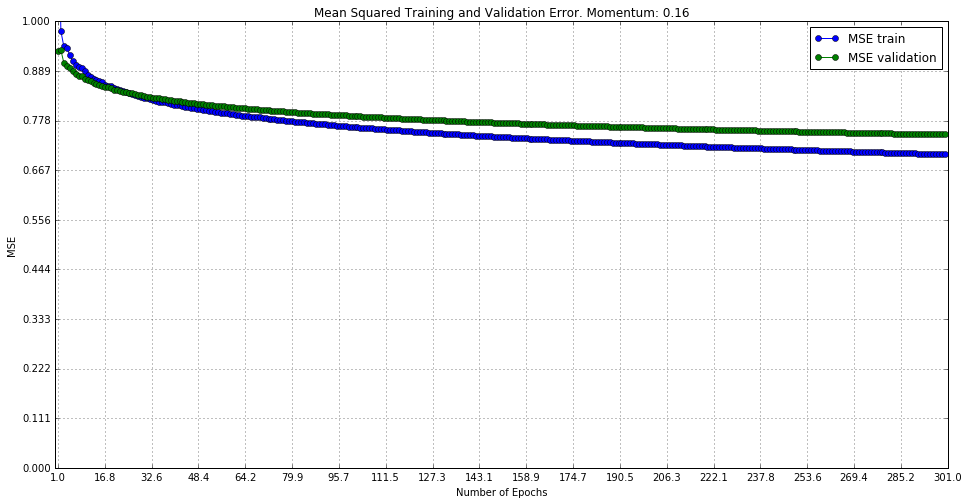

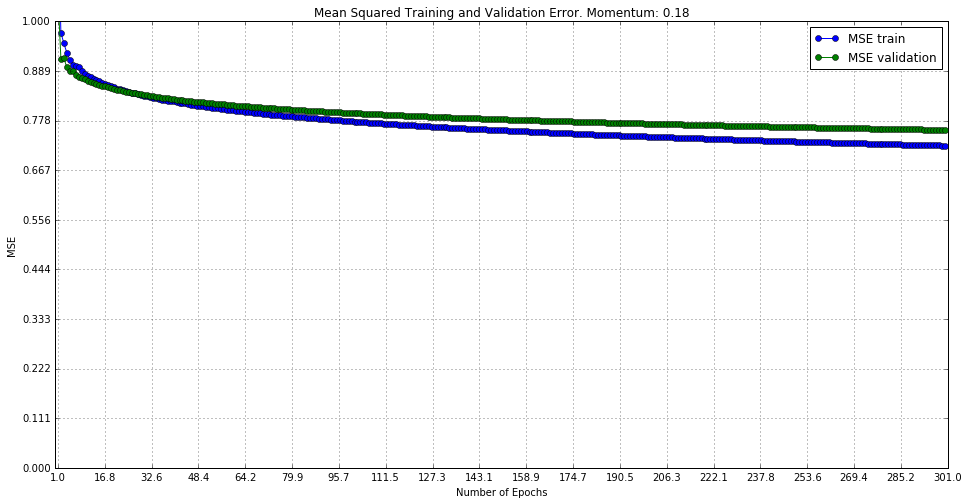

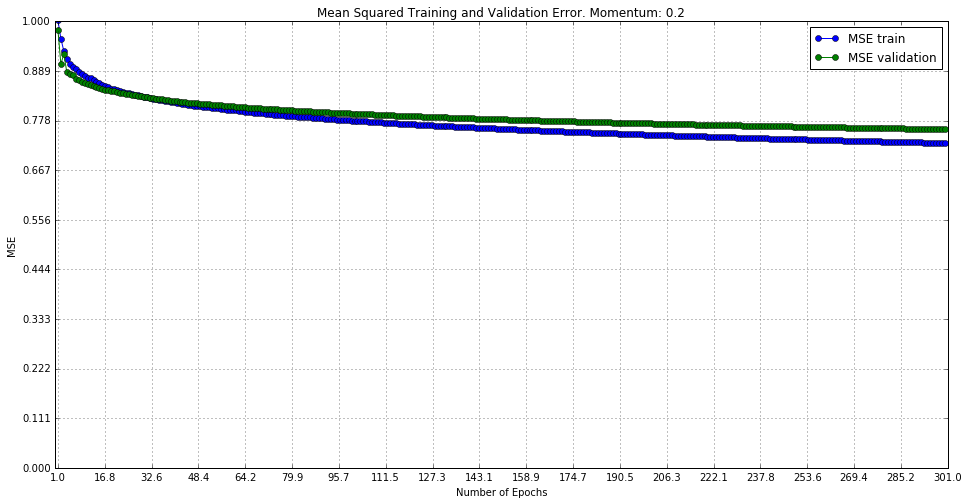

In [36]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Momentum: {0}'.format(momentum[i])
    history_plot(hist, title)

De los gráficos anteriores es importante notar que:
* Cuando se le da baja ponderación al _momentum_ SGD se comporta similar a su versión sin momentum, esto es, dado que el momentum tiene poca influencia, la dirección de búsqueda de pesos $W$ viene mayormente definida por el gradiente $\nabla_{\theta}J(\theta)$.
* A medida que le ponderación del _momentum_ aumenta, se nota una convergencia más estable/uniforme hacia el óptimo, sin embargo es también más lenta. Una posible causa es que para este _dataset_ en partícular, el gradiente acumulado sobre la iteraciones nos da direcciones de búsqueda de los $W$ subóptimas. 
* Para valores muy altos de la ponderación del _momentum_ la convergencia es muy lenta.

El gráfico a continuación soporta tales resultados:

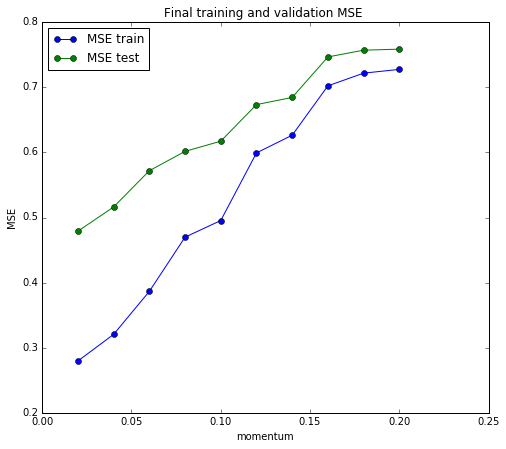

In [37]:
loss = list()
val_loss = list()
for hist in hist_list:
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
# plot
plt.figure(figsize=(8,7))
plt.title('Final training and validation MSE ')
plt.plot(momentum, loss, 'bo-', label='MSE train')
plt.plot(momentum, val_loss, 'go-', label='MSE test')
plt.xlabel('momentum')
plt.ylabel('MSE')
plt.legend(loc=2)
plt.show()

<div id='2j' />
### Parte (j)

En la presente sección se utiliza el modelo de (d), pero variando el tamaño de los _batches_ utilizados, partiendo desde _batches_ de tamaño 1, hasta _batches_ del tamaño del conjunto de entranamiento. 

In [38]:
n_batches = 20
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
print('Number of batch sizes:')
print(batch_sizes)

Number of batch sizes:
[   1.   21.   41.   61.   81.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  299.  319.  339.  359.  379.]


In [ ]:
hist_list = list()

for i in range(n_batches):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, batch_size=batch_sizes[i],
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

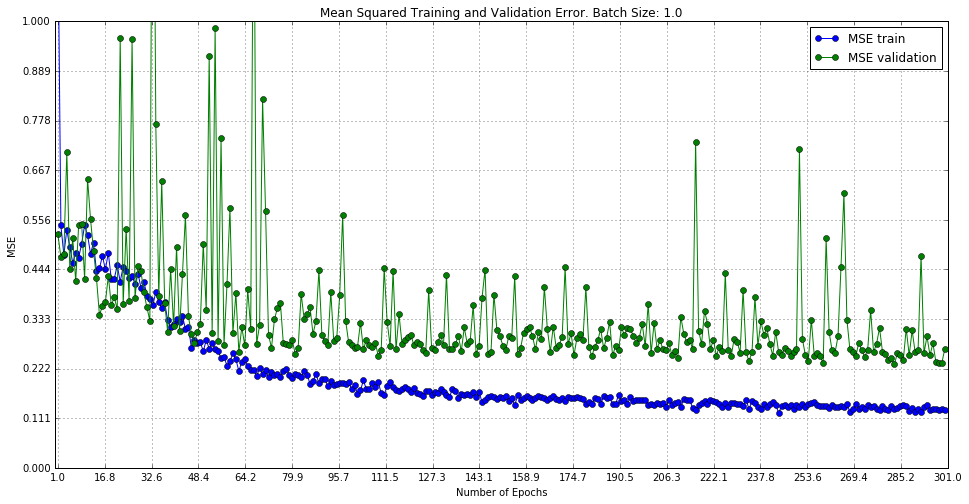

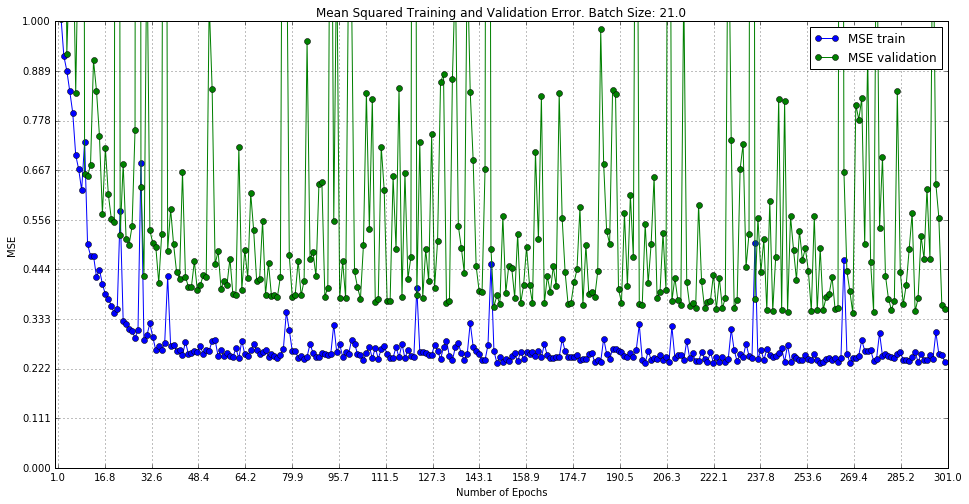

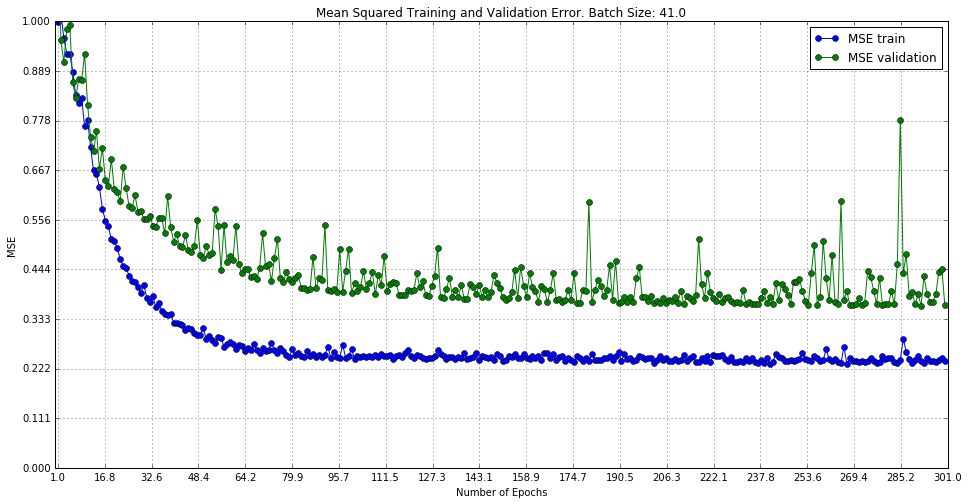

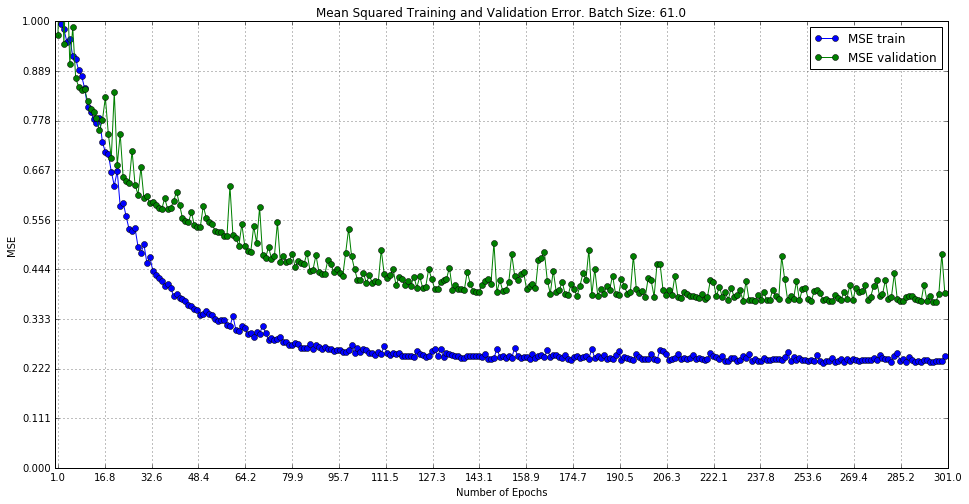

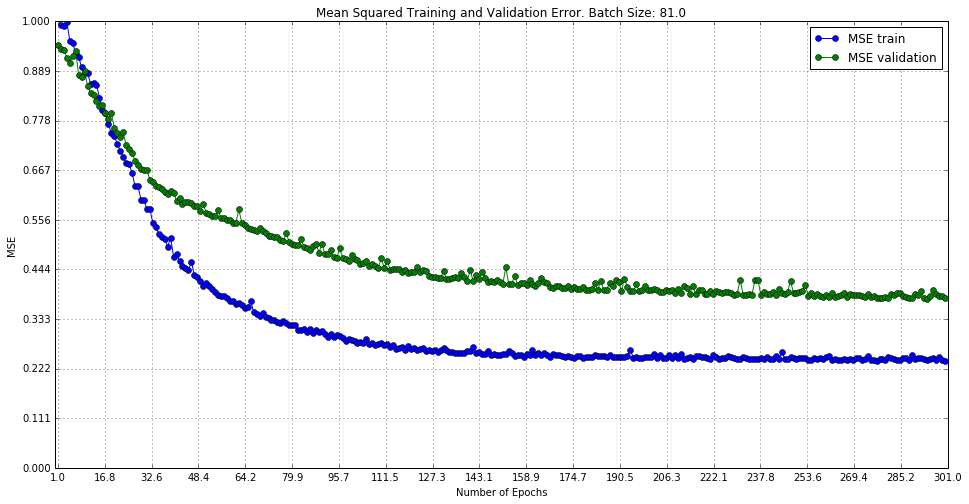

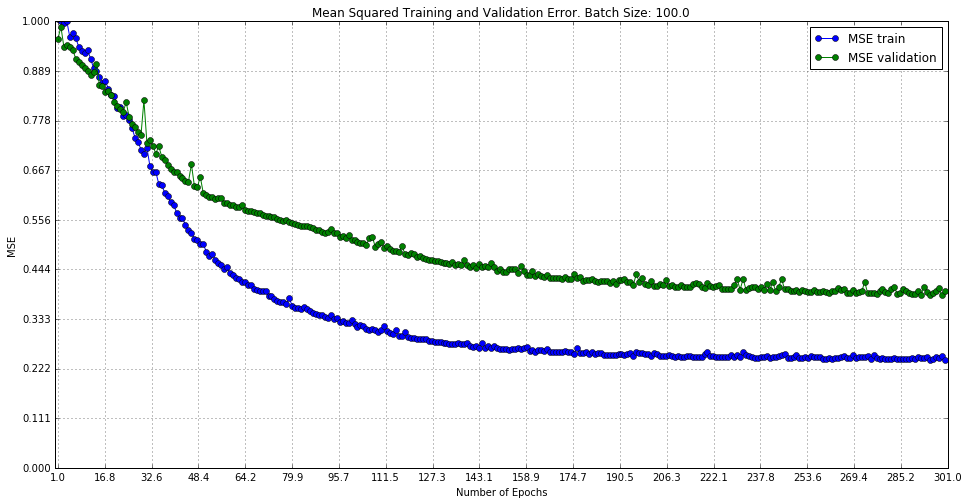

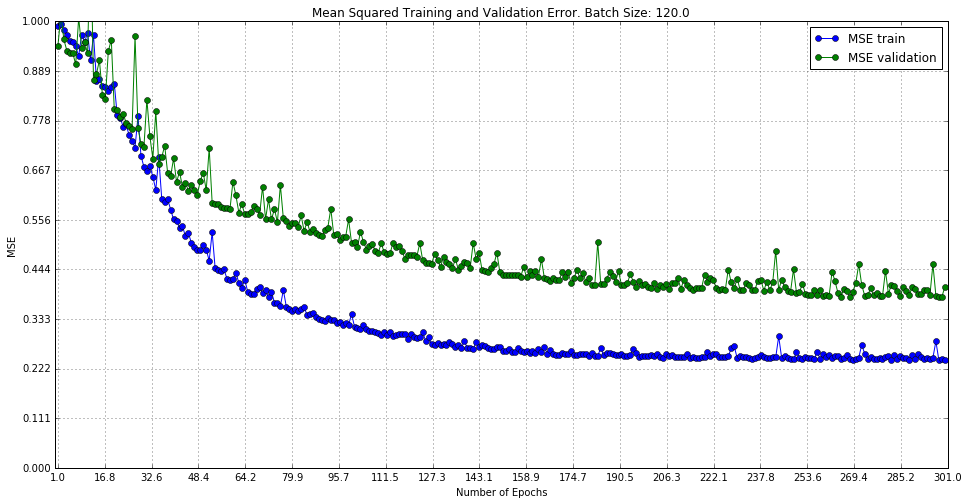

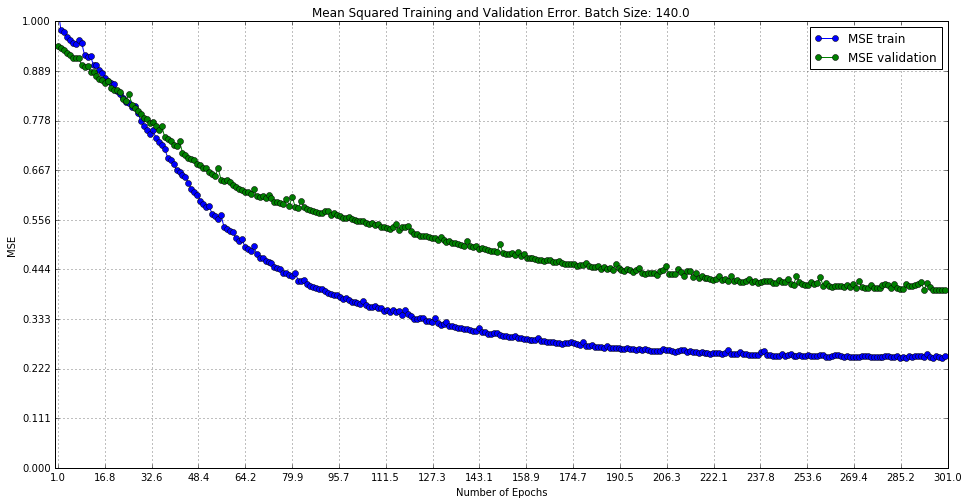

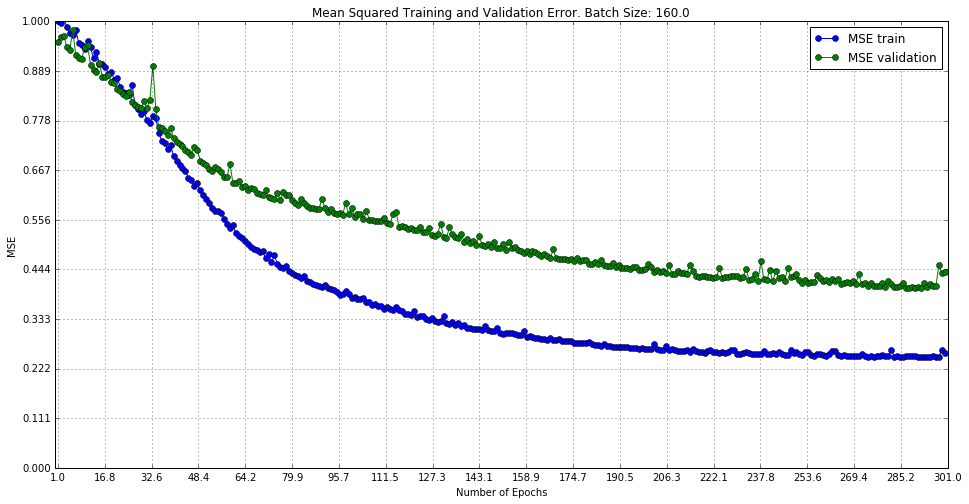

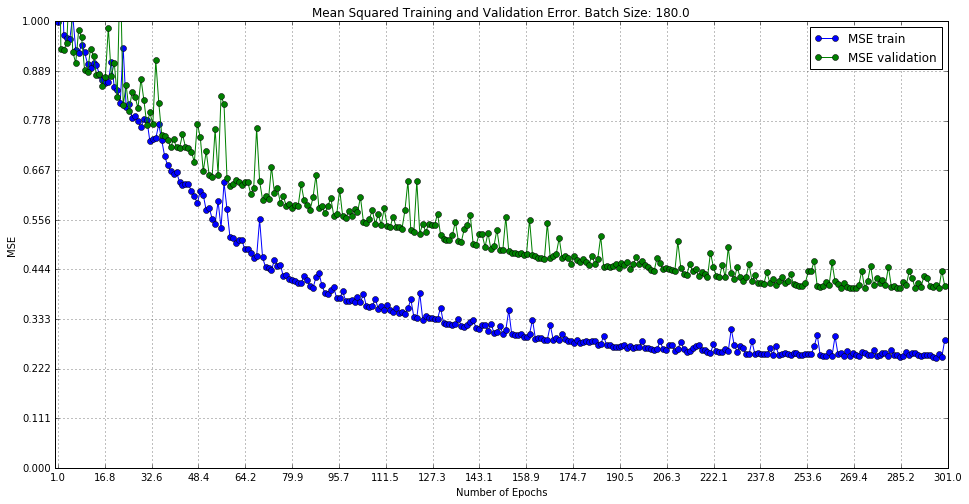

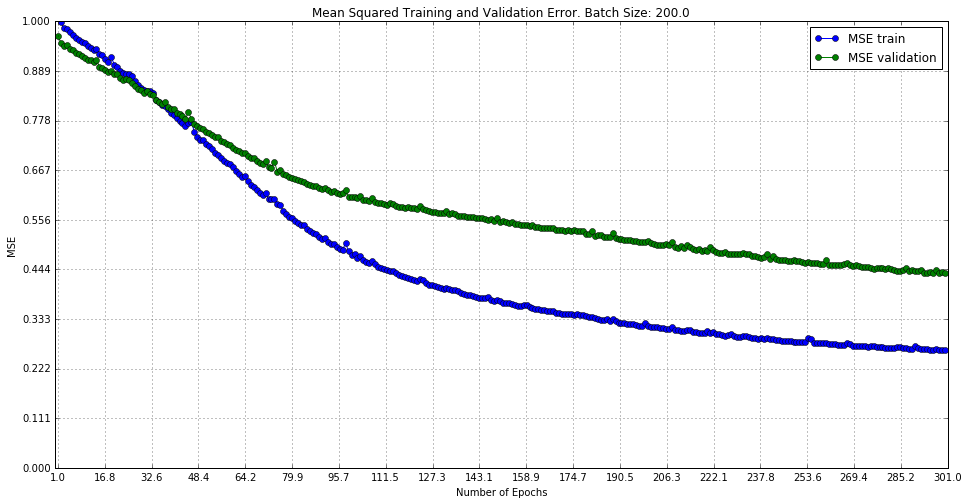

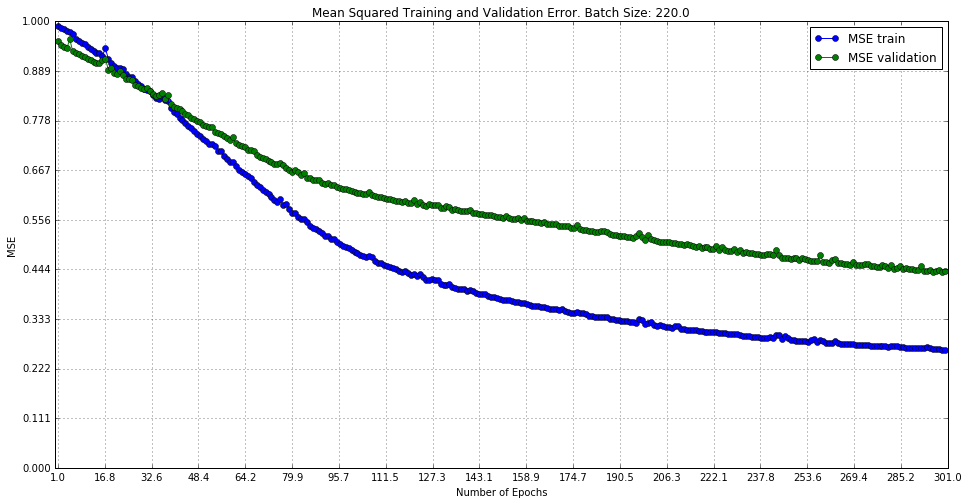

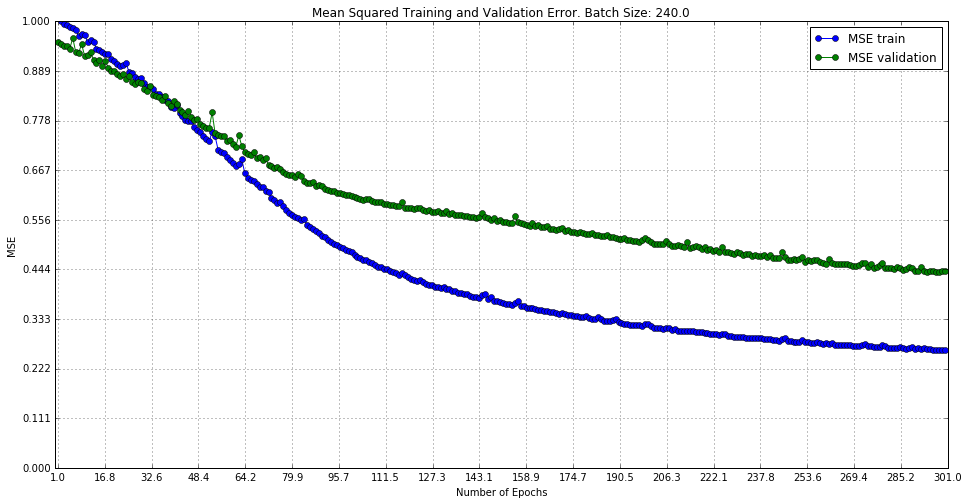

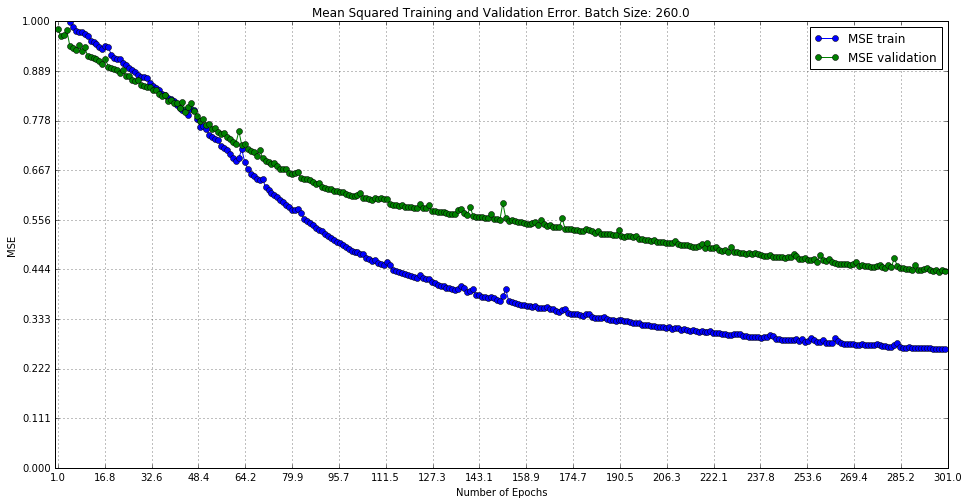

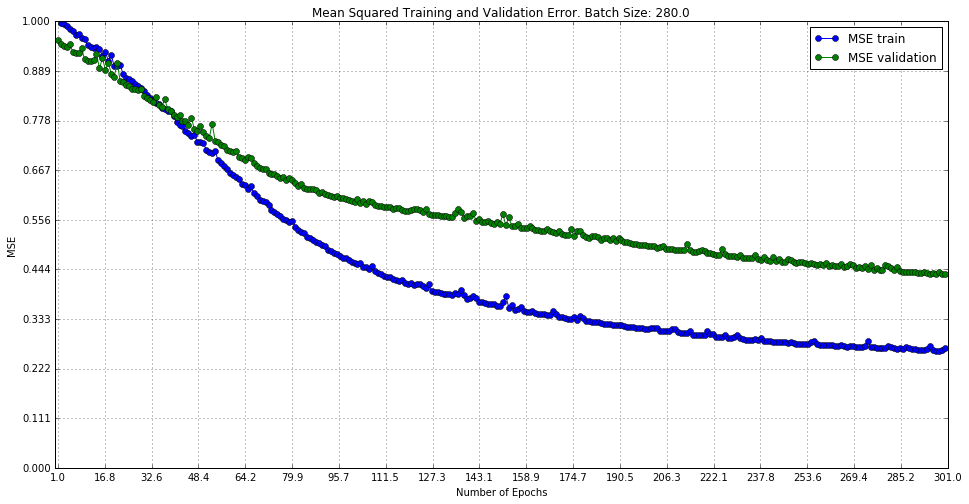

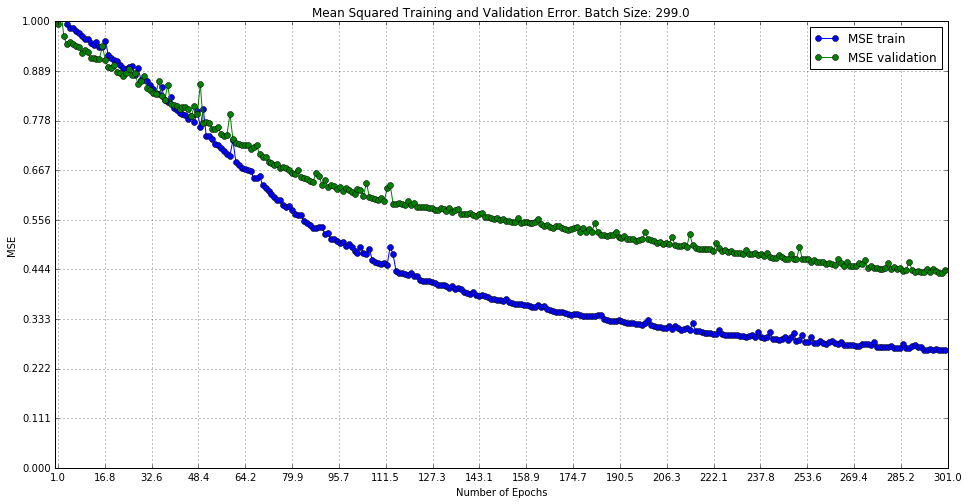

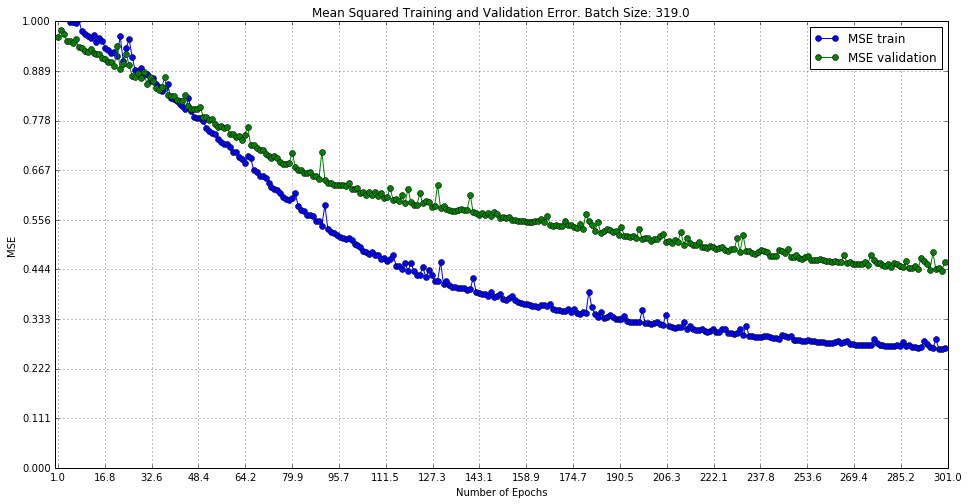

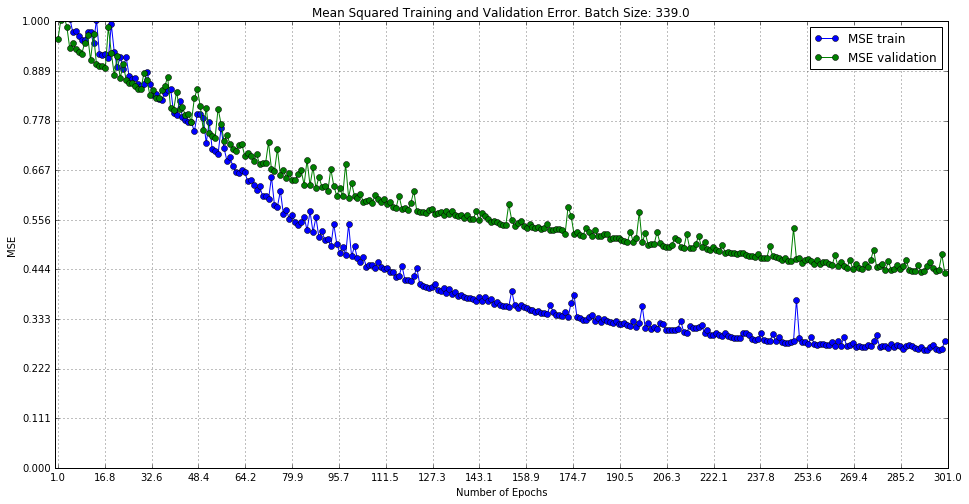

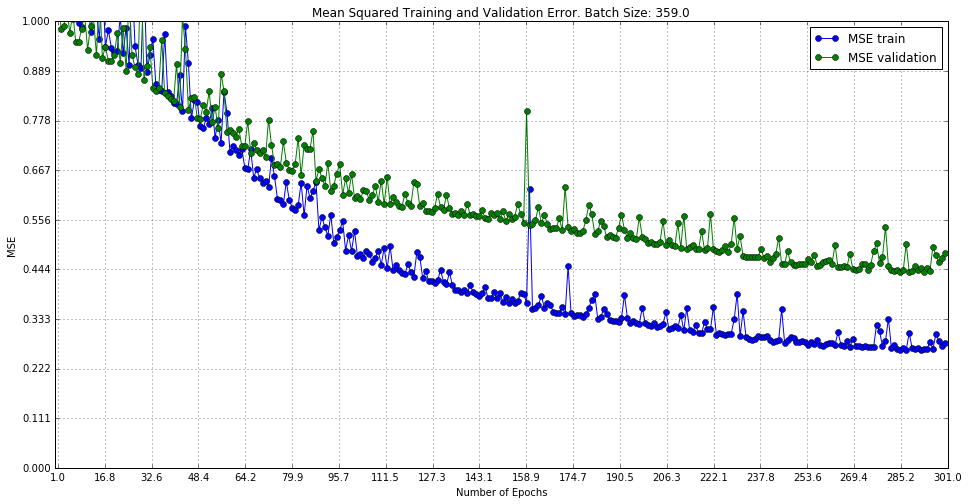

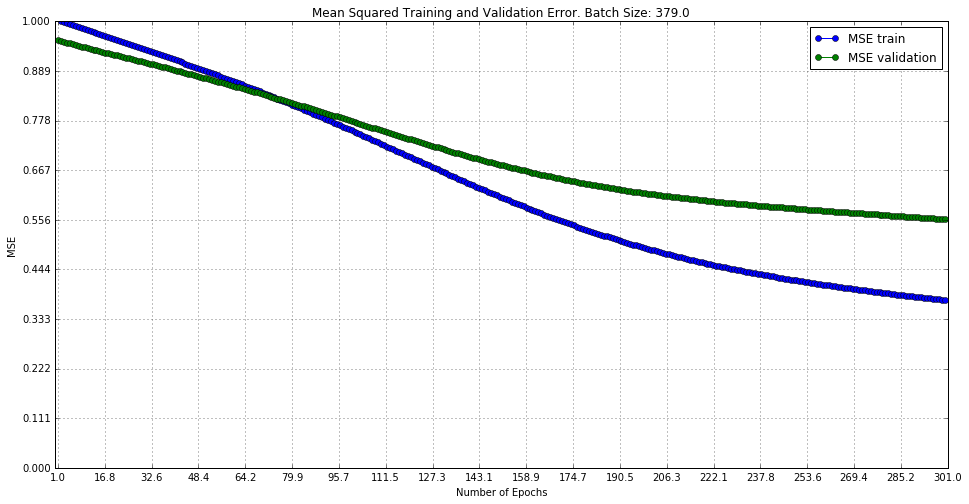

In [40]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Batch Size: {0}'.format(batch_sizes[i])
    history_plot(hist, title)

De los gráficos anteriores es importante notar que:
* Para `batch_sizes` de tamaño muy pequeño, los errores de entrenamiento y validación oscilan mucho, y les cuesta alcanzar la convergencia.
* Para `batch_sizes` de tamaño intermedio, se obtienen mejores resultados tanto en entrenamiento como en validación.
* Ocupar todos los datos de entrenamiento en un solo _batch_ produce una mala performance para esta caso.

El siguiente gráfico soporta los resultados anteriores:

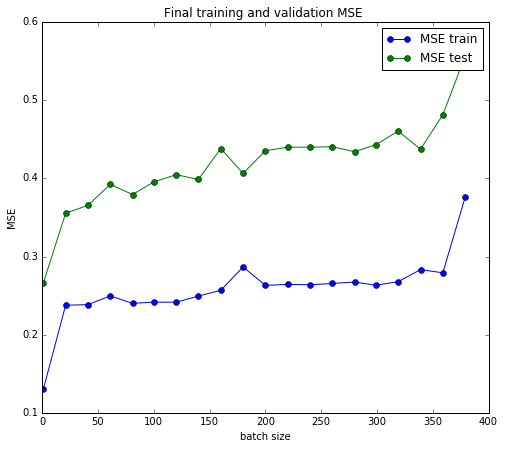

In [41]:
loss = list()
val_loss = list()
for hist in hist_list:
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
# plot
plt.figure(figsize=(8,7))
plt.title('Final training and validation MSE ')
plt.plot(batch_sizes, loss, 'bo-', label='MSE train')
plt.plot(batch_sizes, val_loss, 'go-', label='MSE test')
plt.xlabel('batch size')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

<div id='rec' />
## 3.-  Reconocimiento de imágenes en CIFAR10

<div id='3a' />
### Parte (a)

Función que extrae los datos desde el dataset.
Entrega los datos de entrenamiento (Xtr,Ytr), los de prueba (Xt,Yt) y los de validación (Xv,Yv).

In [3]:
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X = np.array(X,dtype='float64')
        Y = np.array(Y,dtype='float64')
        return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xt, Yt = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    Xtr, Xv = train_test_split(Xtr, test_size=0.10, random_state=0)
    Ytr, Yv = train_test_split(Ytr, test_size=0.10, random_state=0)
    return Xtr, Ytr, Xt, Yt, Xv, Yv

In [4]:
Xtr, Ytr, Xt, Yt, Xv, Yv = load_CIFAR10('Data_3')
print('Conjunto de entrenamiento: \n- Datos: {0} \n- Etiquetas: {1}'.format(Xtr.shape,Ytr.shape))
print('Conjunto de prueba: \n- Datos: {0} \n- Etiquetas: {1}'.format(Xt.shape,Yt.shape))
print('Conjunto de validacion: \n- Datos: {0} \n- Etiquetas: {1}'.format(Xv.shape,Yv.shape))

Conjunto de entrenamiento: 
- Datos: (45000L, 3072L) 
- Etiquetas: (45000L,)
Conjunto de prueba: 
- Datos: (10000L, 3072L) 
- Etiquetas: (10000L,)
Conjunto de validacion: 
- Datos: (5000L, 3072L) 
- Etiquetas: (5000L,)


<div id='3b' />
### Parte (b)

Definimos una función encargada de centrar y escalar (esto último solo si el parámetro scale es True).
Adicionalmente, preparamos las etiquetas para realizar categorical_crossentropy, convirtiendo los escalares en vectores unitarios de largo 10 (número de categorías) con ceros en todas las posiciones distintas al escalar inicial, y un uno en dicha posición.

In [187]:
def scaler_function(Xtr,Xt,Xv,scale=True):
    scaler = StandardScaler(with_std=scale).fit(Xtr)
    Xtr_scaled = scaler.transform(Xtr)
    Xt_scaled = scaler.transform(Xt)
    Xv_scaled = scaler.transform(Xv)
    return Xtr_scaled, Xt_scaled, Xv_scaled
    
Xtr_centered, Xt_centered, Xv_centered = scaler_function(Xtr,Xt,Xv,False) 
Ytr = to_categorical(Ytr)
Yv  = to_categorical(Yv)
Yt  = to_categorical(Yt)

<div id='3c' />
### Parte (c)

Se entrena la red propuesta en el enunciado de la tarea (una capa oculta de 50 unidades) para data centrada, pero no escalada.

In [6]:
model = Sequential()
model.add(Dense(output_dim=50, input_dim=Xtr_centered.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [7]:
hist = model.fit(Xtr_centered, Ytr, nb_epoch=50,
verbose=0, validation_data=(Xv_centered, Yv))

14.5070023473


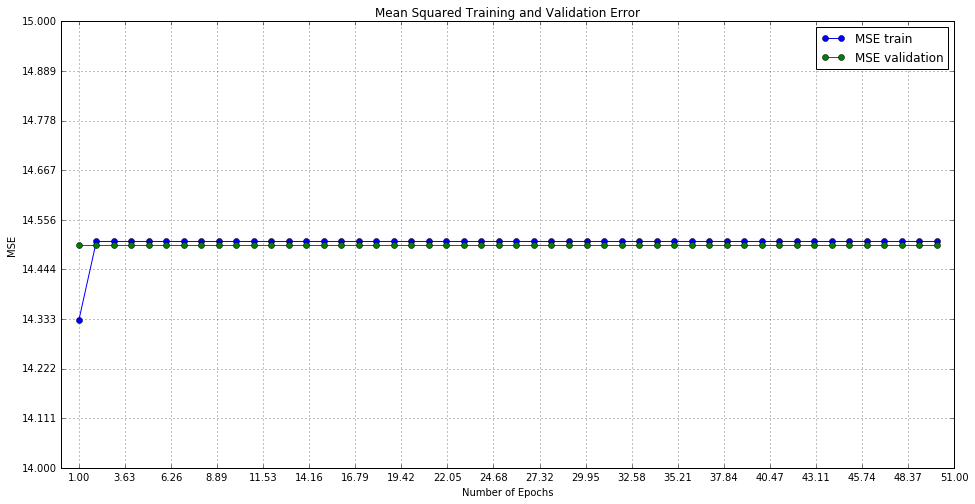

In [11]:
print hist.history['loss'][1]
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(14,15,10))
plt.xlim(0,51)
plt.ylim(14,15)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

Debido a los malos resultados, se decide escalar la data antes de probar otras configuraciones.
Se prueba la misma configuración.

In [188]:
del Xtr_centered, Xt_centered, Xv_centered
Xtr_scaled, Xt_scaled, Xv_scaled = scaler_function(Xtr,Xt,Xv)

In [19]:
model = Sequential()
model.add(Dense(output_dim=50, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [14]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=50,
verbose=0, validation_data=(Xv_scaled, Yv))

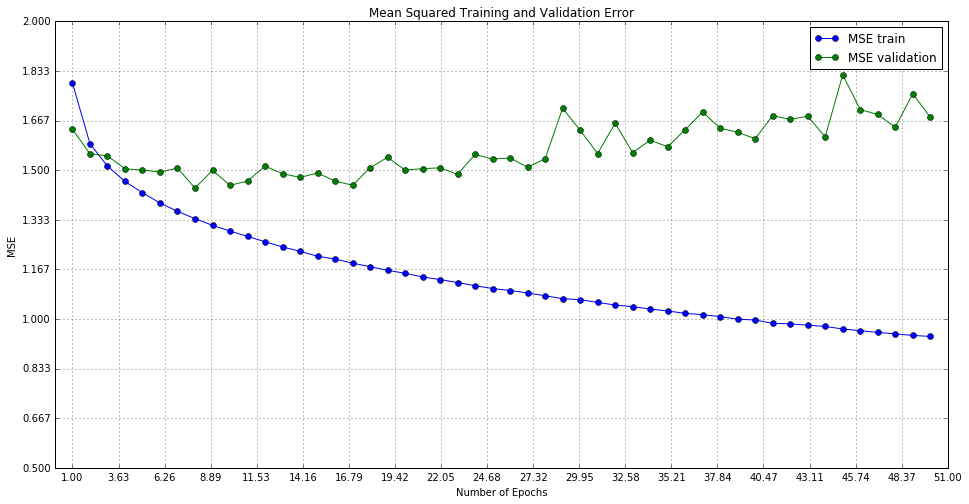

In [17]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2,10))
plt.xlim(0,51)
plt.ylim(0.5,2)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

A continuación, se cambia el método de entrenamiento desde BP estocástico a mini-batches.

In [20]:
model = Sequential()
model.add(Dense(output_dim=50, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [21]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=50, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

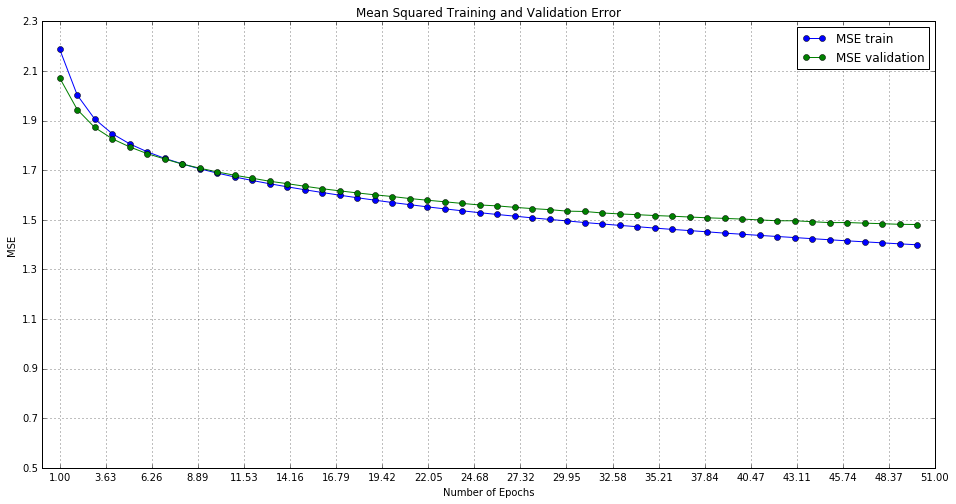

In [24]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2.3,10))
plt.xlim(0,51)
plt.ylim(0.5,2.3)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

En el siguiente experimento, se duplica el número de unidades en la capa oculta, no obteniendo cambios significativos.

In [25]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [26]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=50, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

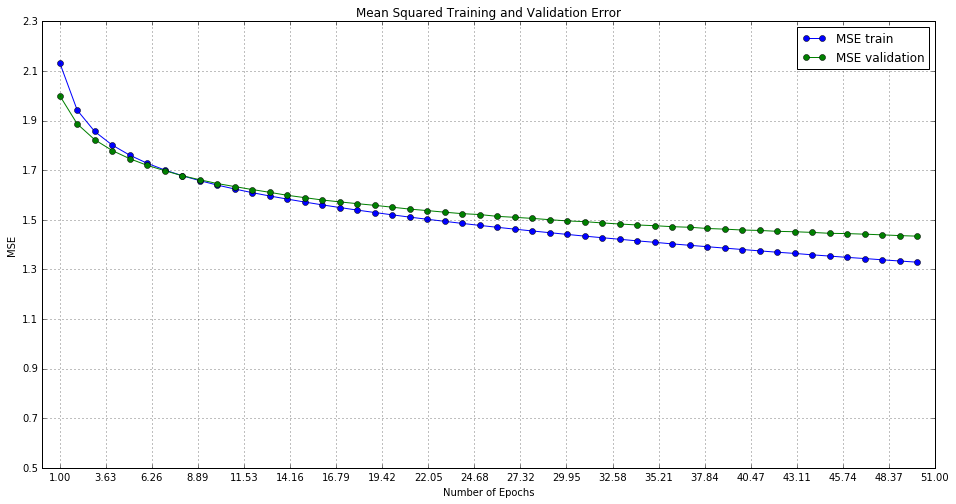

In [27]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2.3,10))
plt.xlim(0,51)
plt.ylim(0.5,2.3)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

A continuación, se agregan dos capas ocultas adicionales con el mismo número de unidades.

In [28]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [29]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=50, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

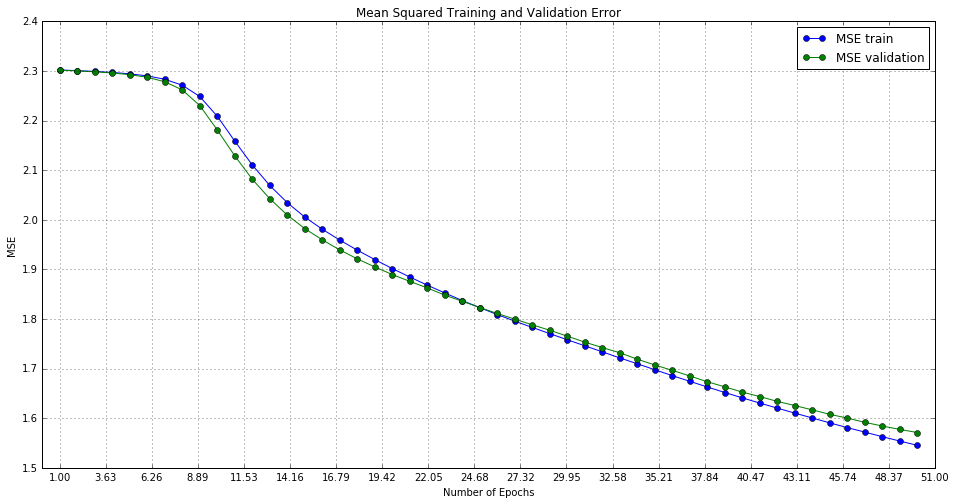

In [31]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(1.5,2.4,10))
plt.xlim(0,51)
plt.ylim(1.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

En esta ocasión, se redujo el tamaño de los batches utilizados.

In [37]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [38]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=50, batch_size=100,
verbose=0, validation_data=(Xv_scaled, Yv))

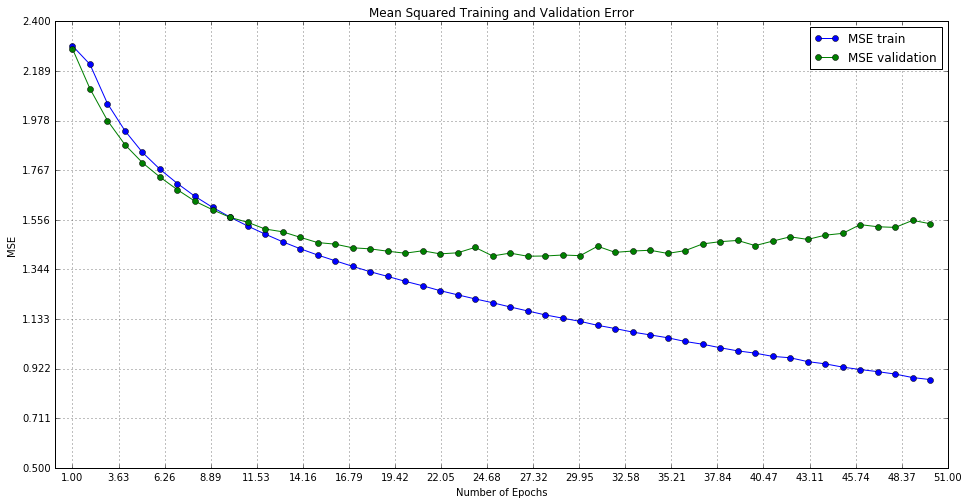

In [41]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,51)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

Debido al tamaño del dataset y el tiempo que toma entrenar las redes, hasta ahora solo se han realizado entrenamientos con nb_epoch=50, por lo que a continuación se repiten algunos experimentos con un número mayor de iteraciones.

In [45]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy')

In [46]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=200, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

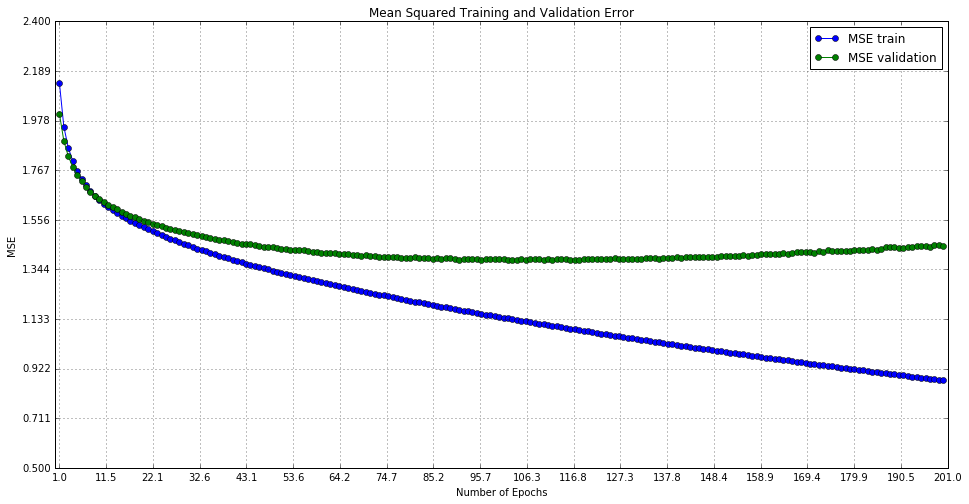

In [47]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,201,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,201)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,201), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,201), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [48]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [49]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=200, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

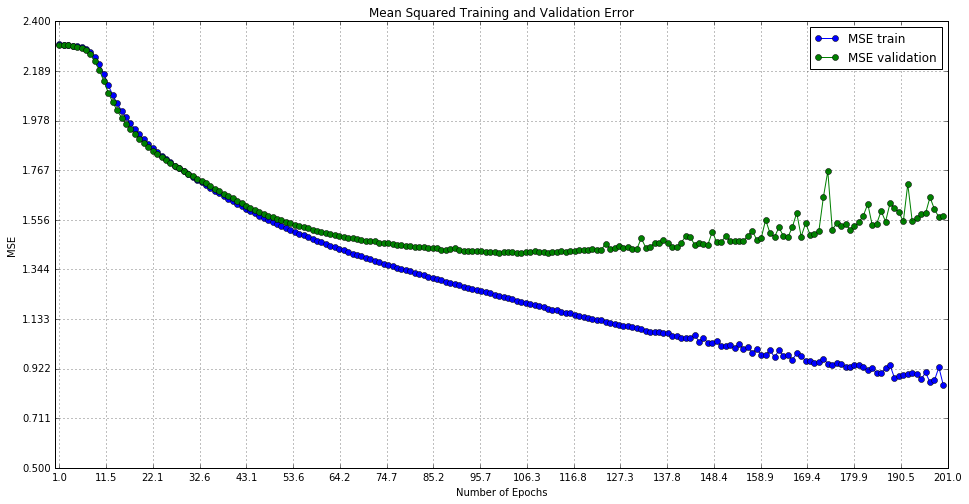

In [50]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,201,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,201)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,201), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,201), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [189]:
model = Sequential()
model.add(Dense(output_dim=1000, input_dim=Xtr_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [190]:
hist = model.fit(Xtr_scaled, Ytr, nb_epoch=200, batch_size=500,
verbose=0, validation_data=(Xv_scaled, Yv))

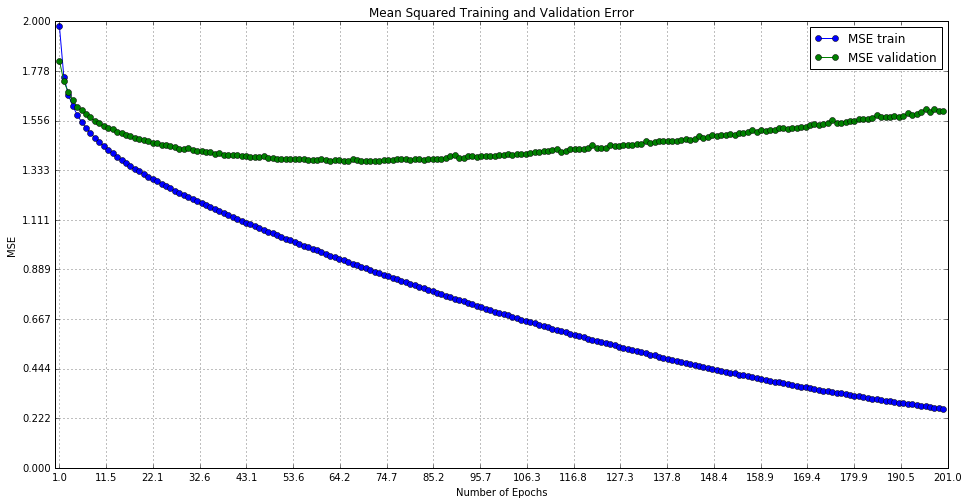

In [191]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,201,20))
ax.set_yticks(np.linspace(0,2,10))
plt.xlim(0,201)
plt.ylim(0,2)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,201), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,201), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [192]:
scores = model.evaluate(Xt,Yt)
print("\n{0}".format(scores))

 9984/10000 [============================>.] - ETA: 0s
10.4950299896


<div id='3d' />
### Parte (d)

Se extraen las features completas de los datos.

In [79]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features
Xtr, Ytr, Xt, Yt, Xv, Yv = load_CIFAR10("Data_3")

In [91]:
features_tr = extract_features(Xtr,[hog_features, color_histogram_hsv])
features_v = extract_features(Xv,[hog_features, color_histogram_hsv])
features_t = extract_features(Xt,[hog_features, color_histogram_hsv])

(45000L, 32L, 32L, 3L)
(5000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


In [95]:
features_tr, features_t, features_v = scaler_function(features_tr,features_t,features_v) 

Ytr = to_categorical(Ytr)
Yv  = to_categorical(Yv)
Yt  = to_categorical(Yt)

Se utiliza una red de tres capas ocultas, con 100 unidades cada una.

In [100]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=features_tr.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(100, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [103]:
hist = model.fit(features_tr, Ytr, nb_epoch=300, batch_size=500,
verbose=0, validation_data=(features_v, Yv))

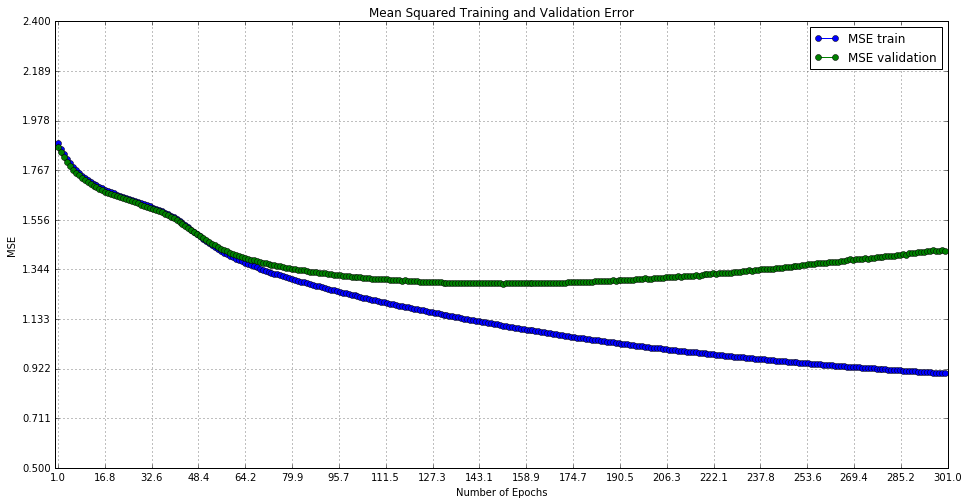

In [104]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,301,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,301)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,301), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,301), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

A continuación, se utiliza una red con una sola capa oculta de 1000 unidades para los mismos datos.

In [105]:
model = Sequential()
model.add(Dense(output_dim=1000, input_dim=features_tr.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [107]:
hist = model.fit(features_tr, Ytr, nb_epoch=300, batch_size=500,
verbose=0, validation_data=(features_v, Yv))

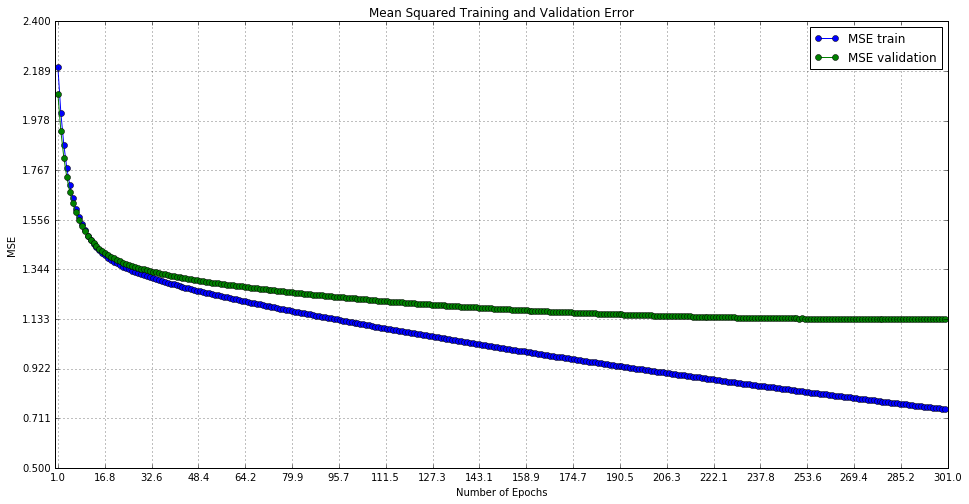

In [108]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,301,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,301)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,301), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,301), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

Esta vez solo tomamos el histograma de colores desde las features.

In [159]:
features_tr = extract_features(Xtr,[color_histogram_hsv])
features_v = extract_features(Xv,[color_histogram_hsv])
features_t = extract_features(Xt,[color_histogram_hsv])

(45000L, 32L, 32L, 3L)
(5000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


In [160]:
features_tr, features_t, features_v = scaler_function(features_tr,features_t,features_v) 

In [167]:
model = Sequential()
model.add(Dense(output_dim=50, input_dim=features_tr.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.001,decay=1e-7), loss='categorical_crossentropy')

In [168]:
hist = model.fit(features_tr, Ytr, nb_epoch=50, 
verbose=0, validation_data=(features_v, Yv))

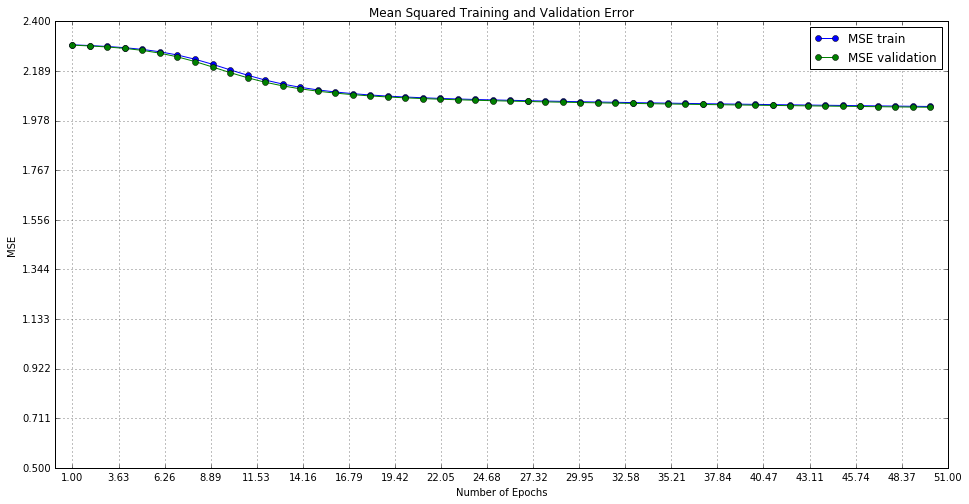

In [169]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,51)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

Finalmente, se extraen las hog features.

In [170]:
features_tr = extract_features(Xtr,[hog_features])
features_v = extract_features(Xv,[hog_features])
features_t = extract_features(Xt,[hog_features])

(45000L, 32L, 32L, 3L)
(5000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


In [171]:
features_tr, features_t, features_v = scaler_function(features_tr,features_t,features_v) 

In [172]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim=features_tr.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(lr=0.01,decay=1e-7), loss='categorical_crossentropy')

In [173]:
hist = model.fit(features_tr, Ytr, nb_epoch=50, batch_size=500,
verbose=0, validation_data=(features_v, Yv))

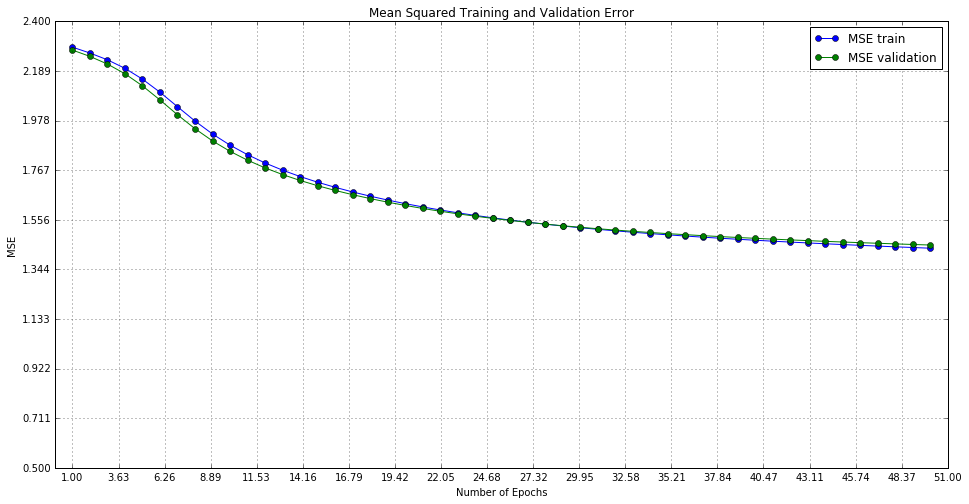

In [174]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.set_xticks(np.linspace(1,51,20))
ax.set_yticks(np.linspace(0.5,2.4,10))
plt.xlim(0,51)
plt.ylim(0.5,2.4)
plt.title('Mean Squared Training and Validation Error')
plt.plot(range(1,51), hist.history['loss'], 'bo-', label='MSE train')
plt.plot(range(1,51), hist.history['val_loss'], 'go-', label='MSE validation')
plt.legend(loc=1)
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [182]:
scores = model.evaluate(features_t,Yt)
print("\n{0}".format(scores))

 8928/10000 [=========================>....] - ETA: 0s
1.46494550037
